In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

CONFIG

In [94]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 5, # 2
        "neurons": 16, # 256
        "nFeatures": 5,
        "dropout": 0.3,
        "lossFunc": "huber_loss", # "huber_loss" Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "AMZN", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64, # 64
        "num_epoch": 100, # 500
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}
# DISPLAY AROUGH ESTIMATE OF HOW MANY DAYS WILL BE USED FOR EACH SECTION
damping = 0.9 # some extra damping for extra days that data isn't collected

offset = config["data"]["offset"]
ts1 = pd.Timestamp('2023-02-25')
ts2 = ts1 + offset
td = ts2 - ts1
days_offset = int(td.days/7*5*damping) # find out the roungh amount of days imported
print(f"{days_offset} Total days used will be roughly imported\n")
print(f"{days_offset* (1-config['data']['validation']-config['data']['testSize'])} Days used for training")
print(f"{days_offset*config['data']['validation']} Days used for validation")
print(f"{days_offset*config['data']['testSize']} Days used for testing")

704 Total days used will be roughly imported

563.2 Days used for training
70.4 Days used for validation
70.4 Days used for testing


Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

if the computer being used is an silicon apple chip then for tensorflow the following must be done

conda install -c apple tensorflow-deps
pip install tensorflow-macos
pip install tensorflow-metal # this is an optional but recommended

pip install pandas numpy matplotlib yahoo_fin scikit-learn

python -m pip install jupyter notebook -U

conda install -c conda-forge -y pandas jupyter

for excel saving
pip install openpyxl

In [75]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [73]:
# create a model using the options in CONFIG
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

# display the model summary
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 50, 32)            4864      
                                                                 
 dropout_186 (Dropout)       (None, 50, 32)            0         
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_187 (Dropout)       (None, 32)                0         
                                                                 
 dense_82 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________


Visualisze the model

In [32]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

DATA LOADER

In [4]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"{ticker} data has been imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    # print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    validationSize = 0.1, # amount of data out of the training data to be used as validation
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize - validationSize) * len(x))
    valSamples = int(validationSize * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]

    data["xval"] = x[trainSamples:trainSamples+valSamples]
    data["yval"] = y[trainSamples:trainSamples+valSamples]

    data["xtest"]  = x[trainSamples+valSamples:]
    data["ytest"]  = y[trainSamples+valSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["valDates"] = ydates[trainSamples:trainSamples+valSamples]
    data["testDates"] = ydates[trainSamples+valSamples:]

    return data

In [13]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])

type(stocks)
print(stocks.keys())
display(stocks)

AMZN data has been imported between 2020-03-07 and the 2023-03-07, for a total of 754 days of data
Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


open       high        low      close   adjclose     volume  \
2020-03-09  88.693001  93.138496  88.064499  90.030502  90.030502  156264000   
2020-03-10  93.543999  94.713501  90.908501  94.591003  94.591003  142666000   
2020-03-11  92.892502  93.566002  90.074997  91.042999  91.042999  112496000   
2020-03-12  86.098999  88.250000  83.750000  83.830498  83.830498  226924000   
2020-03-13  87.750000  89.315498  84.030998  89.250000  89.250000  176194000   
...               ...        ...        ...        ...        ...        ...   
2023-02-28  93.139999  94.690002  92.919998  94.230003  94.230003   43959300   
2023-03-01  93.870003  94.680000  91.589996  92.169998  92.169998   52299500   
2023-03-02  91.410004  92.230003  90.389999  92.129997  92.129997   55509400   
2023-03-03  92.739998  94.940002  92.660004  94.900002  94.900002   55695300   
2023-03-06  95.190002  96.550003  93.739998  93.750000  93.750000   52008400   

           ticker  
2020-03-09   AMZN  
2020-03-10   AMZN  
2020-03-11   AMZN  
2020-03-12   AMZN  
2020-03-13   AMZN  
...           ...  
2023-02-28   AMZN  
2023-03-01   AMZN  
2023-03-02   AMZN  
2023-03-03   AMZN  
2023-03-06   AMZN  

[754 rows x 7 columns]

In [95]:
# process the data
config["data"]["scale"] = True
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["validation"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

print(f"{data.keys()}\n\nHere are the adjusted values downloaded:")

print(data.keys())

print(len(data["raw"]))
print(len(data["ydates"]))


dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])

Here are the adjusted values downloaded:
dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])
754
703


Plot the data imported form the stocks

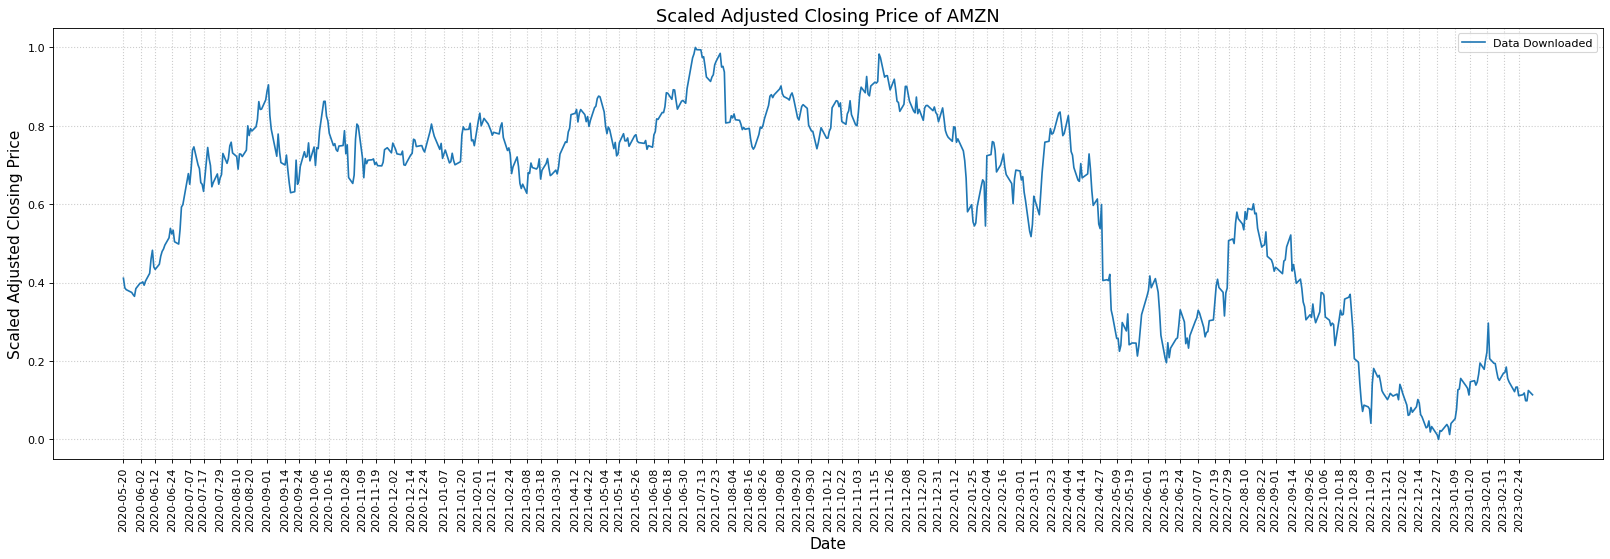

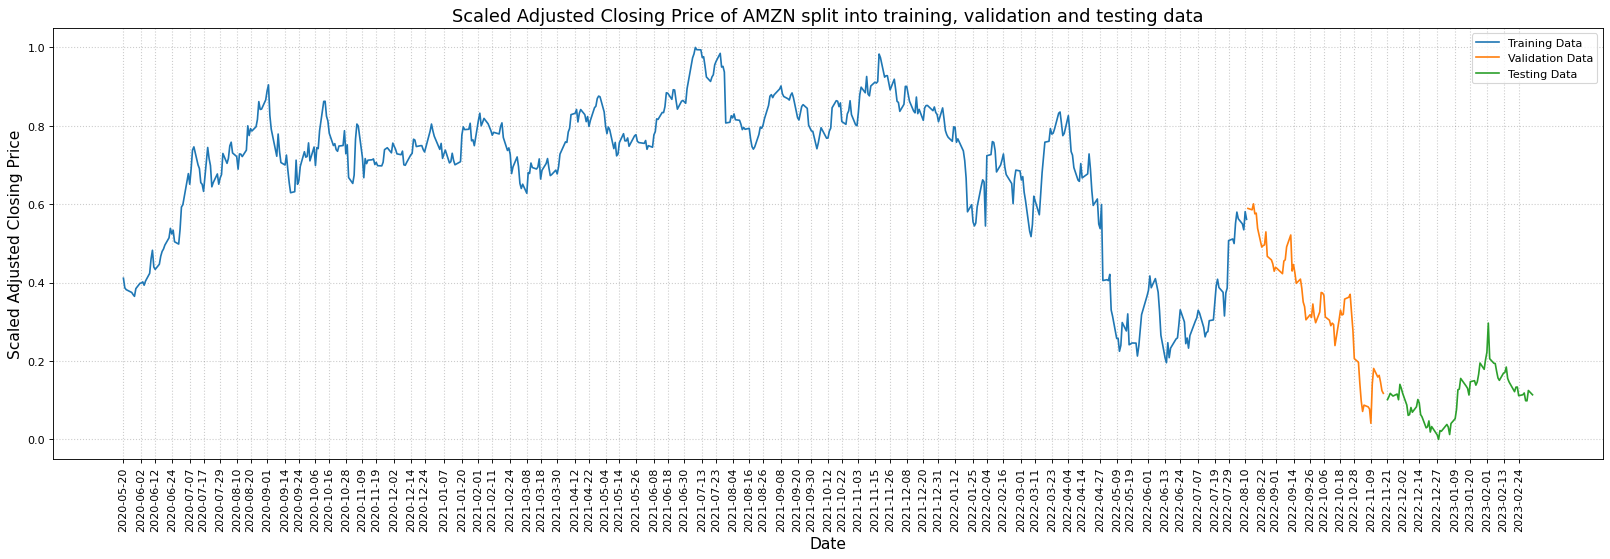

In [96]:
import matplotlib.pyplot as plt

lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
plt.plot(data["ydates"], data["y"])

step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else ""
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend("Data Downloaded".split(","))
# show the plot
plt.show()

plots = "trainDates ytrain,valDates yval,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else ""
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']} split into training, validation and testing data", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend("Training Data,Validation Data,Testing Data".split(","))
# show the plot
plt.show()


Train the model

pip install tensorflow-macos==2.10
pip install tensorflow-metal==0.6

In [97]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

# create a new model to be trained
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
history = model.fit(data["xtrain"], data["ytrain"],
                    batch_size=config["training"]["batch_size"],
                    epochs=config["training"]["num_epoch"],
                    validation_data=(data["xval"], data["yval"]),
                    verbose=1) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Epoch 1/100


2023-03-07 17:19:48.297545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:48.818560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:50.452260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:51.277119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:52.302236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:53.410448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:19:55.543947: I tensorflow/core/grappler/optimizers/cust

9/9 [==============================] - ETA: 0s - loss: 0.1588 - mean_absolute_error: 0.5226

2023-03-07 17:20:28.111957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:20:28.469696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:20:29.287308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:20:30.012427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:20:30.611276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 17:20:31.407556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 50s 4s/step - loss: 0.1588 - mean_absolute_error: 0.5226 - val_loss: 0.0116 - val_mean_absolute_error: 0.1235
Epoch 2/100
9/9 [==============================] - 9s 892ms/step - loss: 0.0384 - mean_absolute_error: 0.2215 - val_loss: 0.1270 - val_mean_absolute_error: 0.4852
Epoch 3/100
9/9 [==============================] - 6s 691ms/step - loss: 0.0316 - mean_absolute_error: 0.1969 - val_loss: 0.0405 - val_mean_absolute_error: 0.2524
Epoch 4/100
9/9 [==============================] - 5s 549ms/step - loss: 0.0275 - mean_absolute_error: 0.1868 - val_loss: 0.0449 - val_mean_absolute_error: 0.2693
Epoch 5/100
9/9 [==============================] - 4s 525ms/step - loss: 0.0246 - mean_absolute_error: 0.1735 - val_loss: 0.0590 - val_mean_absolute_error: 0.3184
Epoch 6/100
9/9 [==============================] - 5s 581ms/step - loss: 0.0199 - mean_absolute_error: 0.1563 - val_loss: 0.0366 - val_mean_absolute_error: 0.2450
Epoch 7/100
9/9 [===================

Plot the results

loss  mean_absolute_error  val_loss  val_mean_absolute_error
0   0.158771             0.522617  0.011591                 0.123535
1   0.038402             0.221473  0.127021                 0.485182
2   0.031579             0.196939  0.040497                 0.252421
3   0.027516             0.186791  0.044853                 0.269263
4   0.024563             0.173462  0.058952                 0.318419
..       ...                  ...       ...                      ...
95  0.003121             0.058977  0.018153                 0.171663
96  0.003070             0.058738  0.014564                 0.149526
97  0.003445             0.062055  0.012508                 0.136244
98  0.003120             0.059873  0.017309                 0.166689
99  0.003212             0.060622  0.019414                 0.178725

[100 rows x 4 columns]

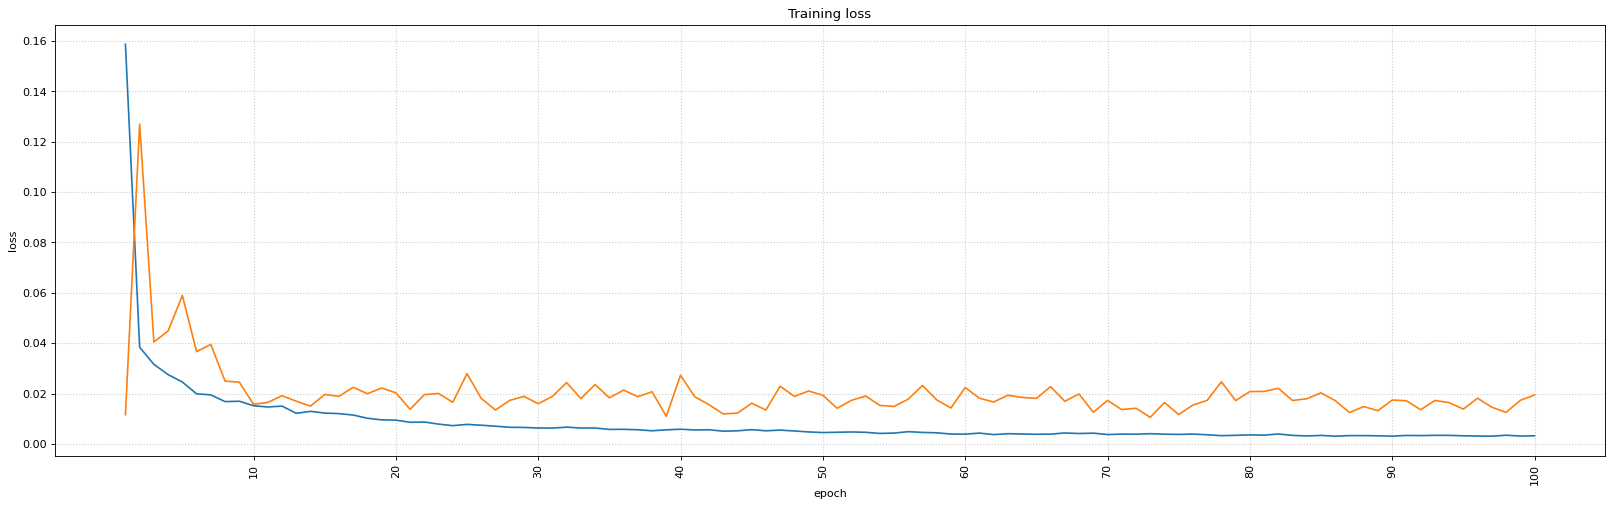

In [98]:
train_history = pd.DataFrame(history.history)
display(train_history)

fig = plt.figure(figsize=(25, 7), dpi=80)
plt.plot(range(1,101), train_history['loss'])
plt.plot(range(1,101), train_history['val_loss'])
# train_history.plot(figsize=(20,7))
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10,101,10), rotation='vertical') 
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()


2023-02-27 19:32:34.894567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:34.963098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:35.059564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 80ms/step


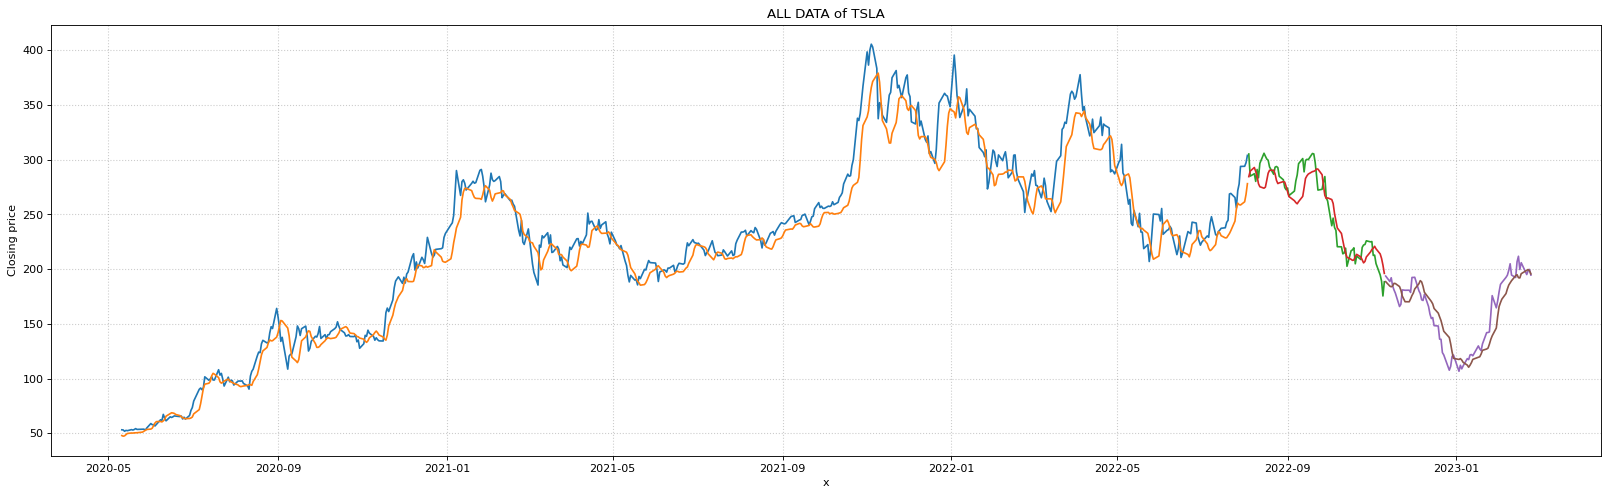

In [38]:
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))


# for the training
pred_yval = model.predict(data["xval"])
yval = data["yval"]
# scaler = config["data"]["scaler"]
pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))


# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))





# plot the results
# # TRAINING DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(ytrain)
# plt.plot(pred_ytrain)
# plt.title(f"Training data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.legend("Actual,Neural Network".split(","))
# plt.show()
# # VALIDATION DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(yval, "*-") # actual data
# plt.plot(pred_yval, "*-")
# plt.title(f"Validation data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.show()
# ALL 3 TOGETHER
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
plt.plot(data["trainDates"],ytrain) # train data
plt.plot(data["trainDates"], pred_ytrain)
plt.plot(data["valDates"], yval) # val data
plt.plot(data["valDates"], pred_yval)
plt.plot(data["testDates"], ytest) # test data
plt.plot(data["testDates"], pred_ytest)
plt.title(f"ALL DATA of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()



Other methods to compare against

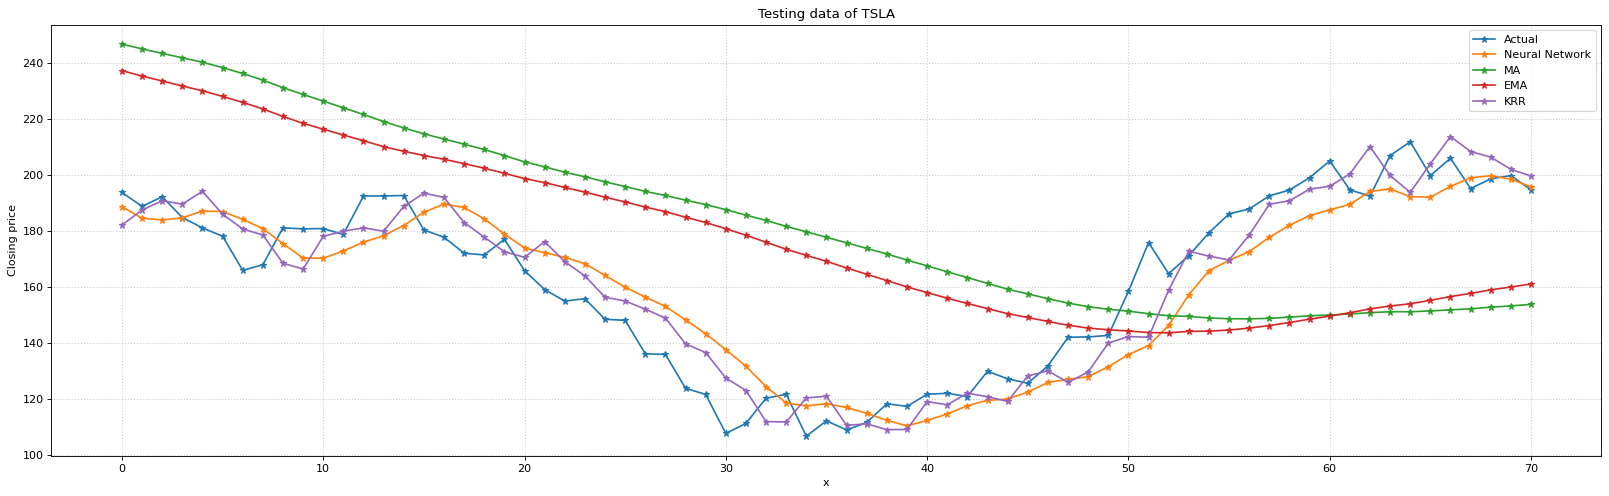

In [39]:
# TEST DATA

# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
# Train the model on the training data
krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
# Make predictions on the test data
pred_krr = krr.predict(data['xtest'][:, -1, :])
pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


# calcualte the price using a simple moving average
pred_ma = np.mean(data["xtest"], axis = 1)
pred_ma = pred_ma[:, 0] # take only the adjclose price out
pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

# calculate the price using exponential moving average
pred_ema = data["xtest"][:, :, 0] # only take the 
# pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
weights = np.exp(np.linspace(-1, 0, config["nn"]["window"]))
weights /= weights.sum()
pred_ema = pred_ema@weights
pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
plt.plot(ytest, "*-") # actual data
plt.plot(pred_ytest, "*-") # prediction made by neural network
plt.plot(pred_ma, "*-")
plt.plot(pred_ema, "*-")
plt.plot(pred_krr, "*-")
plt.title(f"Testing data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
plt.show()

 RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [40]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# def calc_da(y_true, y_pred):
#     count = 0
#     predictions = len(y_true)-1
#     for i in range(predictions):
#         true_dir = y_true[i+1]-y_true[i]
#         pred_dir = y_pred[i+1]-y_pred[i]

#         # if true_dir > 0 and pred_dir > 0 or true_dir <= 0 and pred_dir <= 0:
#         if true_dir * pred_dir > 0:
#             count += 1
#         # print(true_grad/abs(true_grad))
#     return count/predictions
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# compare all the following data
pairs = [[ytrain, pred_ytrain, 'Training NN'],
         [yval, pred_yval, 'Validation NN'],
         [ytest, pred_ytest, 'Testing NN'],
         [ytest, pred_krr, 'Testing KRR'],
         [ytest, pred_ma, 'Testing MA'],
         [ytest, pred_ema, 'Testing EMA']
         ]

d = {}
for pair in pairs:
    d[pair[2]] = []
    d[pair[2]].append(calc_mse(pair[0], pair[1]))
    d[pair[2]].append(calc_rmse(pair[0], pair[1]))
    # d[pair[2]].append(calc_mae(pair[0], pair[1]))
    d[pair[2]].append(calc_mape(pair[0], pair[1]))
    d[pair[2]].append(calc_da(pair[0], pair[1]))
    d[pair[2]].append(calc_cod(pair[0], pair[1]))

df = pd.DataFrame(data=d)
df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
df

Training NN  Validation NN  Testing NN  Testing KRR   Testing MA  \
MSE    295.007437     212.245888  172.759693   117.299685  2316.624984   
RMSE    17.175781      14.568661   13.143808    10.830498    48.131331   
MAPE     5.448532       4.751548    7.227501     5.835578    29.803178   
DA       0.482206       0.463768    0.628571     0.542857     0.514286   
R²       0.956515       0.854657    0.824787     0.881034    -1.349525   

      Testing EMA  
MSE   1798.903505  
RMSE    42.413483  
MAPE    25.905475  
DA       0.585714  
R²      -0.824451

Trading stocks

Neural Netowrk         KRR Moving Average Exp Moving Average
Percentage                70.73%       2.14%         10.17%              0.00%
Buy in                £ 1,000.00  £ 1,000.00     £ 1,000.00         £ 1,000.00
Cash out              £ 1,707.28  £ 1,021.45     £ 1,101.70         £ 1,000.00
14.0 weeks profit       £ 707.28     £ 21.45       £ 101.70             £ 0.00
Profit per month        £ 307.53      £ 9.33        £ 44.22             £ 0.00

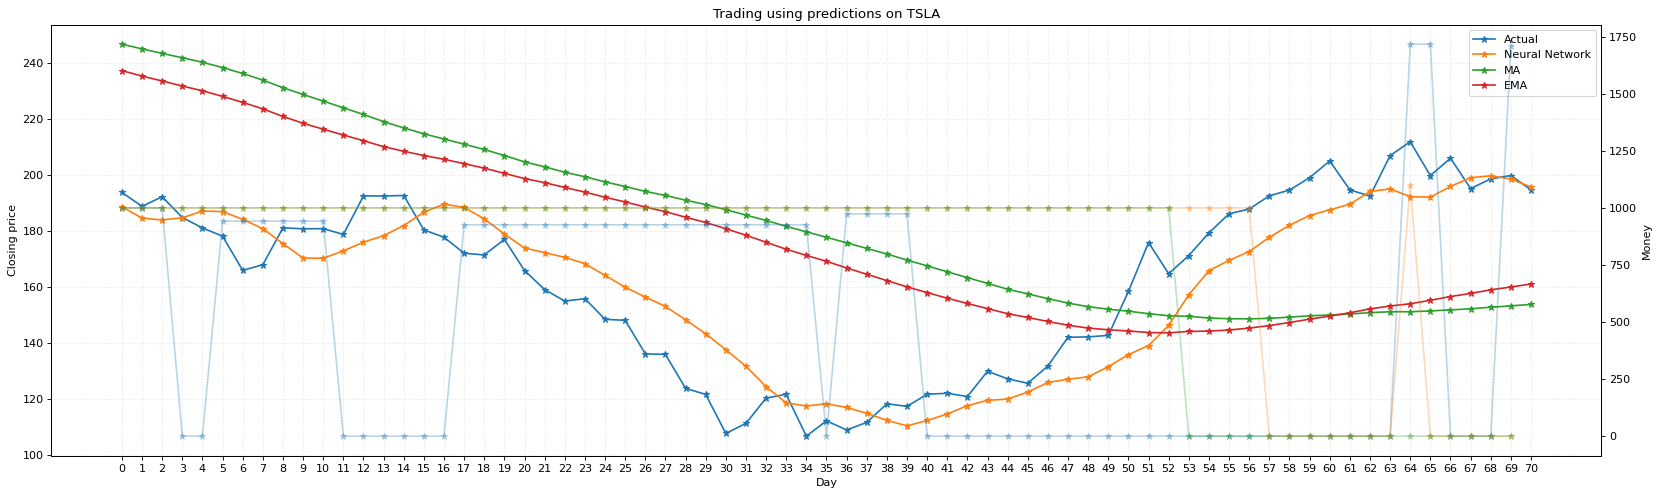

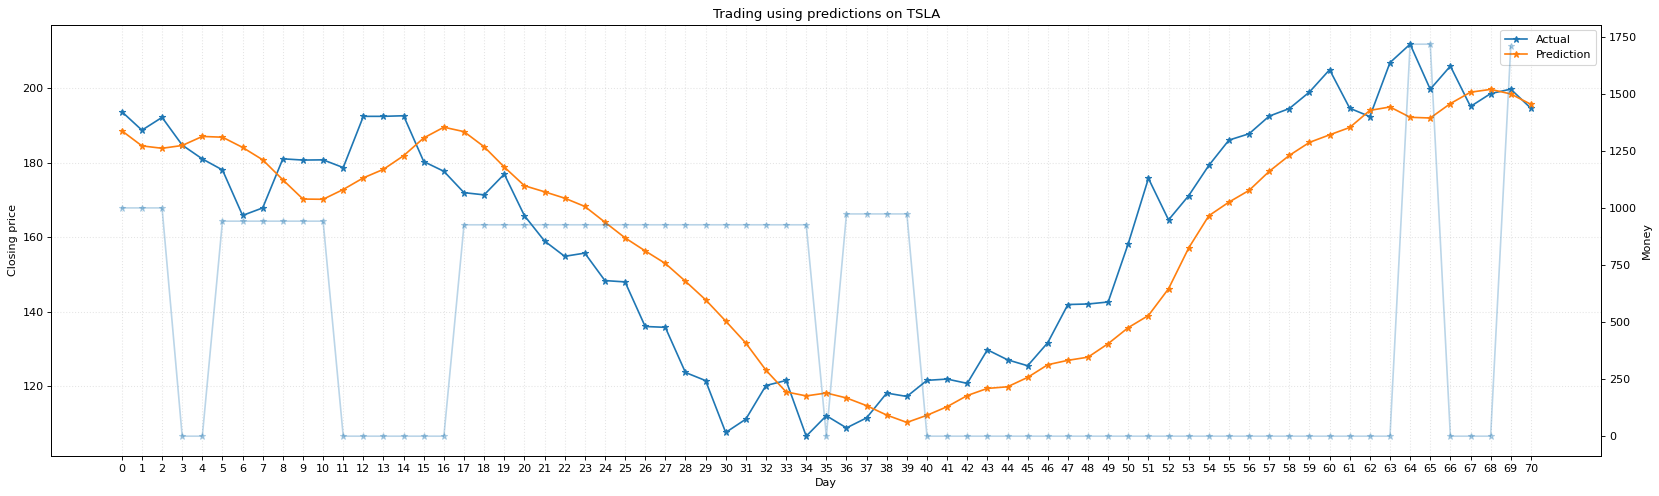

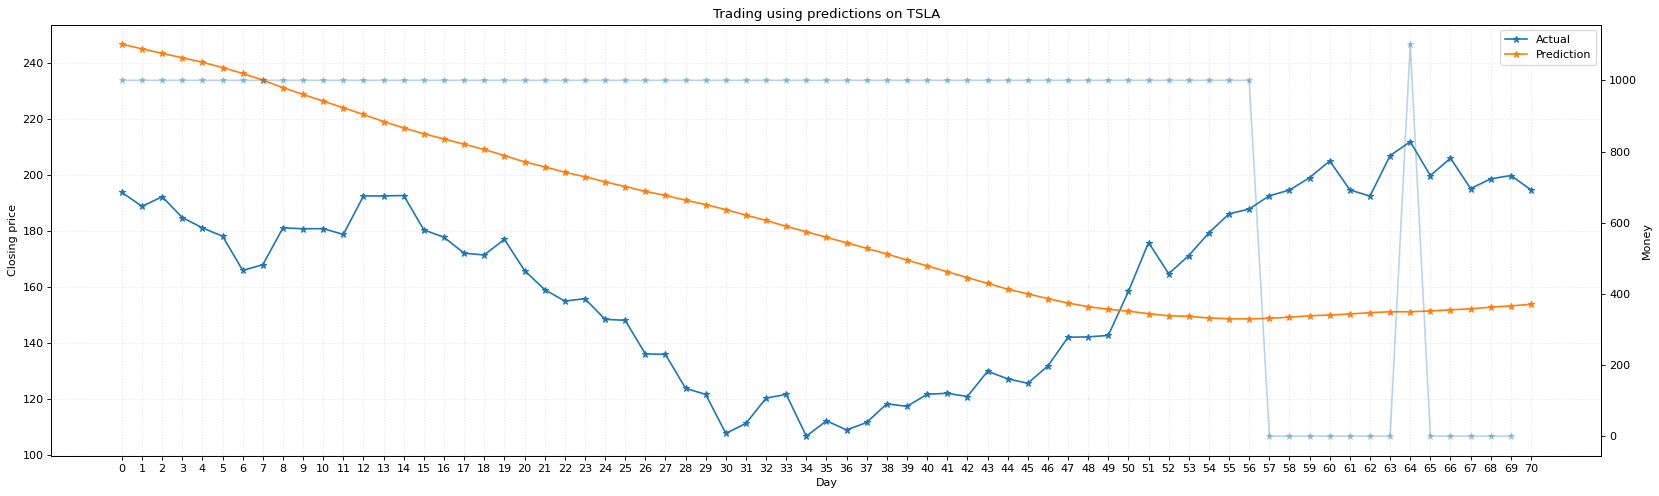

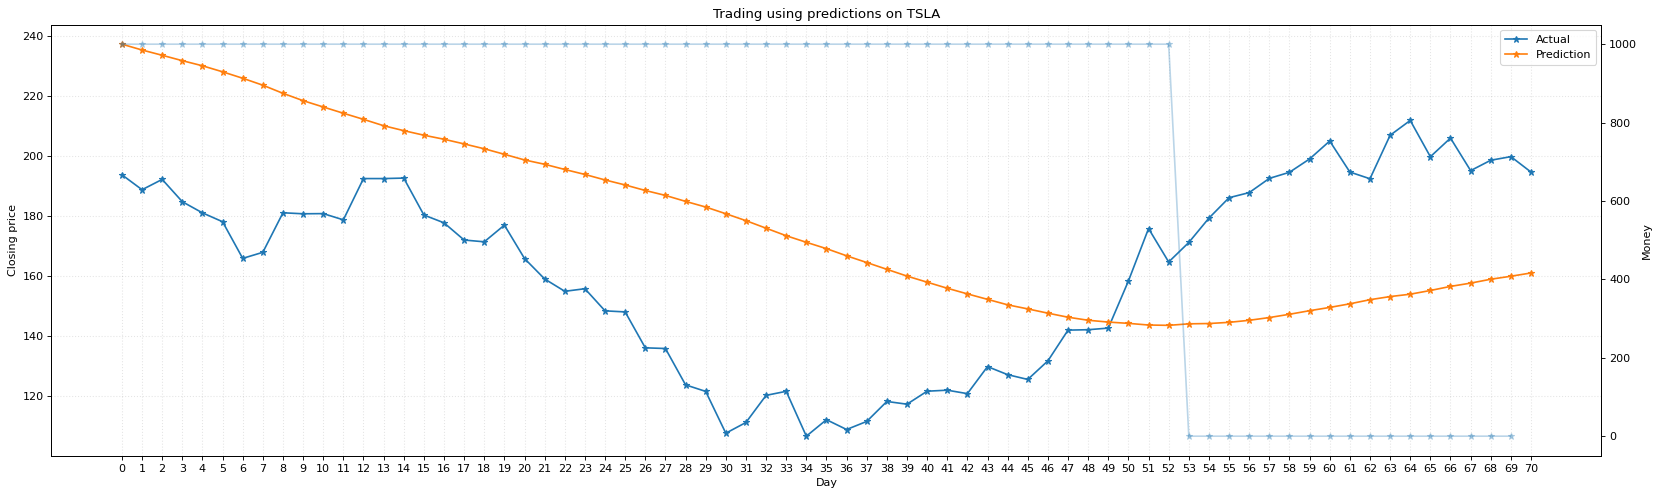

In [41]:
def trader(money, actual, predictions):
    owned_shares = 0
    history = [money]
    
    for i in range(len(predictions)-2):
        # keep track of what is owned
        history.append(money)

        # find out the prices
        # prev_price, curr_price, next_price = actual[i], actual[i+1], predictions[i+2]
        prev_price, curr_price, next_price = predictions[i], predictions[i+1], predictions[i+2]
        # buy
        if prev_price > curr_price and next_price > curr_price:
            if money == 0:
                # print(f"Can't buy {money, owned_shares}")
                continue
            # work out how many shares it buys
            owned_shares = money/actual[i+1]
            money = 0
            # print(f'buy {money, owned_shares}')
        # sell
        elif prev_price < curr_price and next_price < curr_price:
            if owned_shares == 0:
                # print(f"Can't sell {money, owned_shares}")
                continue
            money = owned_shares*actual[i+1]
            owned_shares = 0
            # print(f'sell {money, owned_shares}')
        # hold
        else:
            # print('do nothing')
            continue
    
    return history

def calc_profit(money_history, initial_money):
    # find the last value that wasn't 0
    for i in reversed(range(len(money_history))):
        if money_history[i] != 0:
            # the final value of money
            break # money_history[i] is the final value that isn't 0
    money_made = money_history[i]-initial_money
    percentage = money_made/initial_money*100
    spacing = 0
    spacer = "."
    stats = [f"{percentage:.2f}%".rjust(spacing, spacer),
         f"£ {initial_money:,.2f}".rjust(spacing, spacer),
         f"£ {money_history[i]:,.2f}".rjust(spacing, spacer),
         f"£ {money_made:,.2f}".rjust(spacing, spacer),
         f"£ {money_made/(len(money_history)/30.437):,.2f}".rjust(spacing, spacer)]
    return stats

# plot the trades
def plot_trades(base, plots, alpha = 0.3, hold_on = 1):
    if hold_on:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        for plot in plots:
            ax1.plot(plot[0], "*-") # prediction
            ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Neural Network,MA,EMA".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
    # if not then create a different plot for each data set
    for plot in plots:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        ax1.plot(plot[0], "*-") # prediction
        ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Prediction".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
# initial, final = 40, -1
# ytest = ytest[initial:final]
# pred_ytest = pred_ytest[initial:final]
# pred_MA = pred_MA[initial:final]
# pred_EMA = pred_EMA[initial:final]

initial_money = 1000
nn_money = trader(initial_money, ytest, pred_ytest)
ma_money = trader(initial_money, ytest, pred_ma)
ema_money = trader(initial_money, ytest, pred_ema)
krr_money = trader(initial_money, ytest, pred_krr)
# calcualte and display the results of the trader
d = {"Neural Netowrk": calc_profit(nn_money, initial_money),
     "KRR": calc_profit(krr_money, initial_money),
     "Moving Average": calc_profit(ma_money, initial_money),
     "Exp Moving Average": calc_profit(ema_money, initial_money)
     }
df = pd.DataFrame(d, index = ['Percentage', 'Buy in', 'Cash out', f"{len(nn_money)/5} weeks profit", 'Profit per month'])
display(df) # display the dataframe

to_plot = [[pred_ytest, nn_money],
           [pred_ma, ma_money],
           [pred_ema, ema_money]
           ]
# plot the trading results
plot_trades(ytest, to_plot, 0.3, 1)


TESTS with different parameters

AMZN
AMZN data has been imported between 2020-03-07 and the 2023-03-07, for a total of 754 days of data


('AMZN', 90, 2, 0.1, 0.1, True) 90
1/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 19:56:43.101612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:56:43.362503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:56:46.718557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:56:52.870820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:56:57.142824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:57:33.108935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:57:33.652048: I tensorflow/core/grappler/optimizers/cust

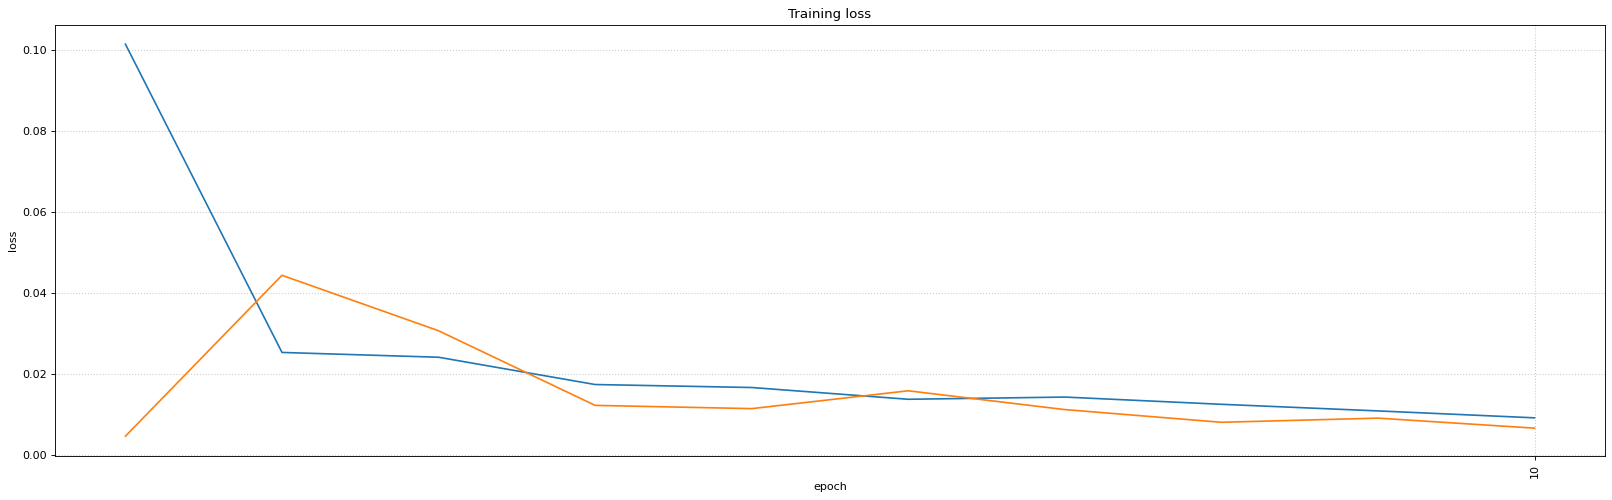

2/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 19:58:21.372313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:58:21.611520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:58:24.702062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:58:29.882796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:58:33.834083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:59:02.450778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 19:59:02.603093: I tensorflow/core/grappler/optimizers/cust

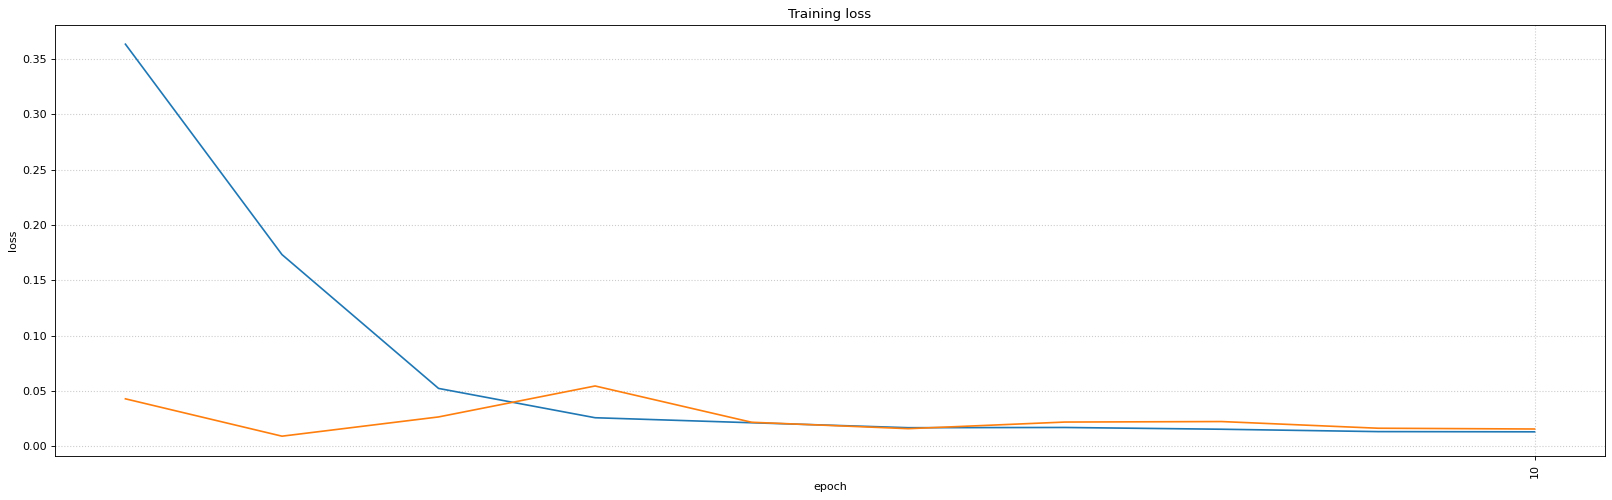

3/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 20:00:14.985842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:15.915589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:18.998323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:23.648197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:27.771042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:58.396228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:00:58.501898: I tensorflow/core/grappler/optimizers/cust

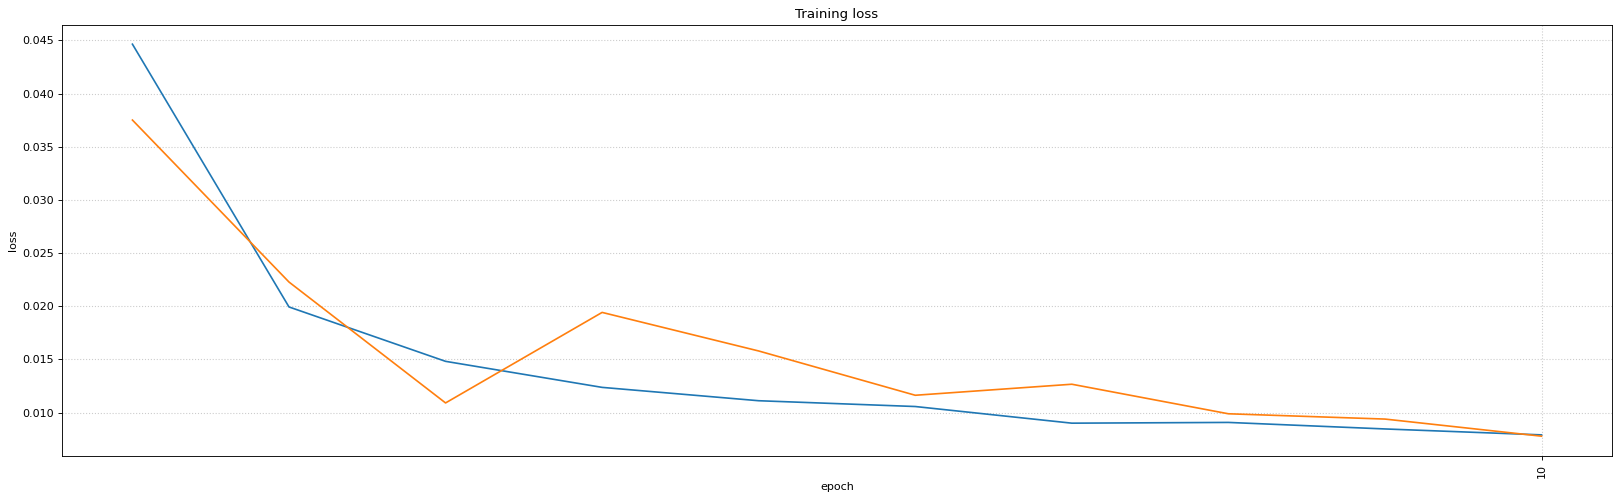

4/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:01:48.649911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:01:48.958784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:01:52.339439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:01:57.181809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:02:01.196375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:02:37.445468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:02:37.569891: I tensorflow/core/grappler/optimizers/cust

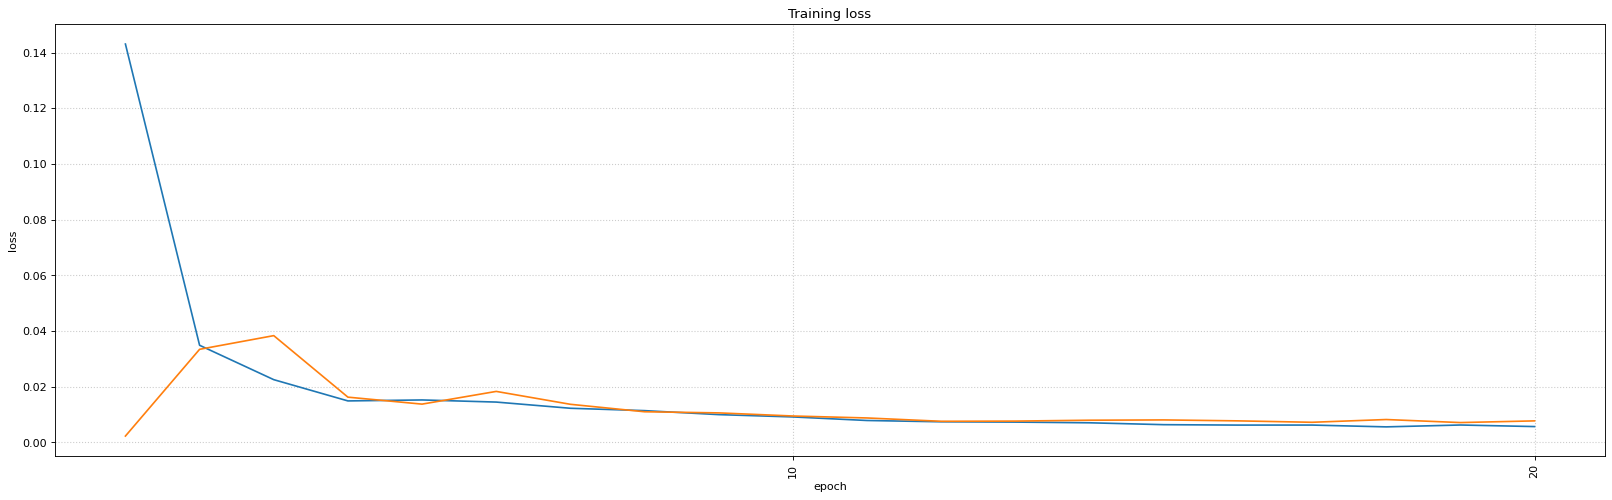

5/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:03:38.679589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:03:38.979058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:03:42.215127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:03:47.219786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:03:50.943812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:04:22.146678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:04:22.260658: I tensorflow/core/grappler/optimizers/cust

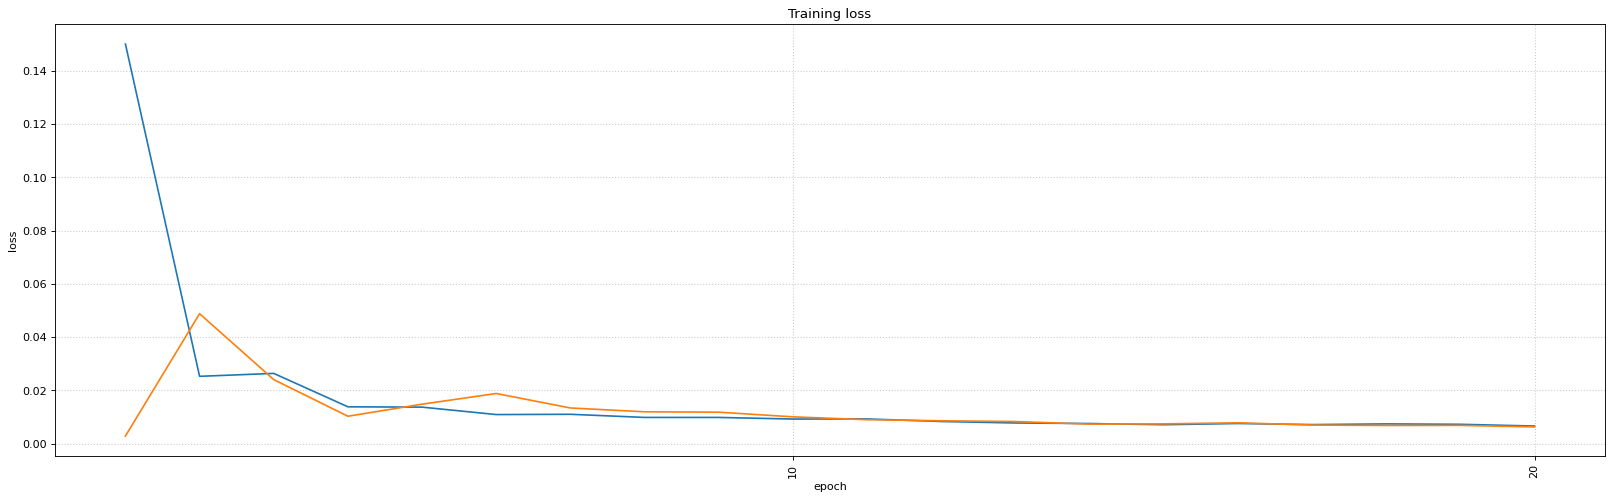

6/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:05:15.670601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:05:15.958723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:05:19.242331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:05:24.307618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:05:28.688147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:06:05.960528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:06:06.323198: I tensorflow/core/grappler/optimizers/cust

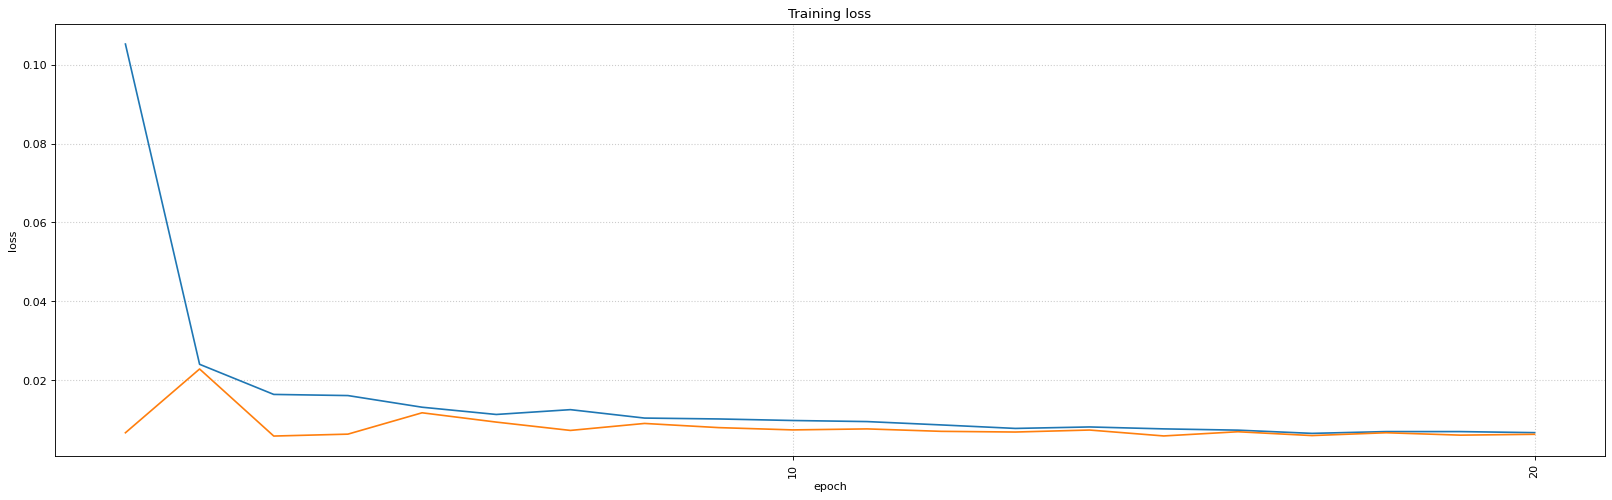

7/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:07:08.485650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:08.790748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:11.961568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:16.992299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:20.832630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:56.886386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:07:57.595330: I tensorflow/core/grappler/optimizers/cust

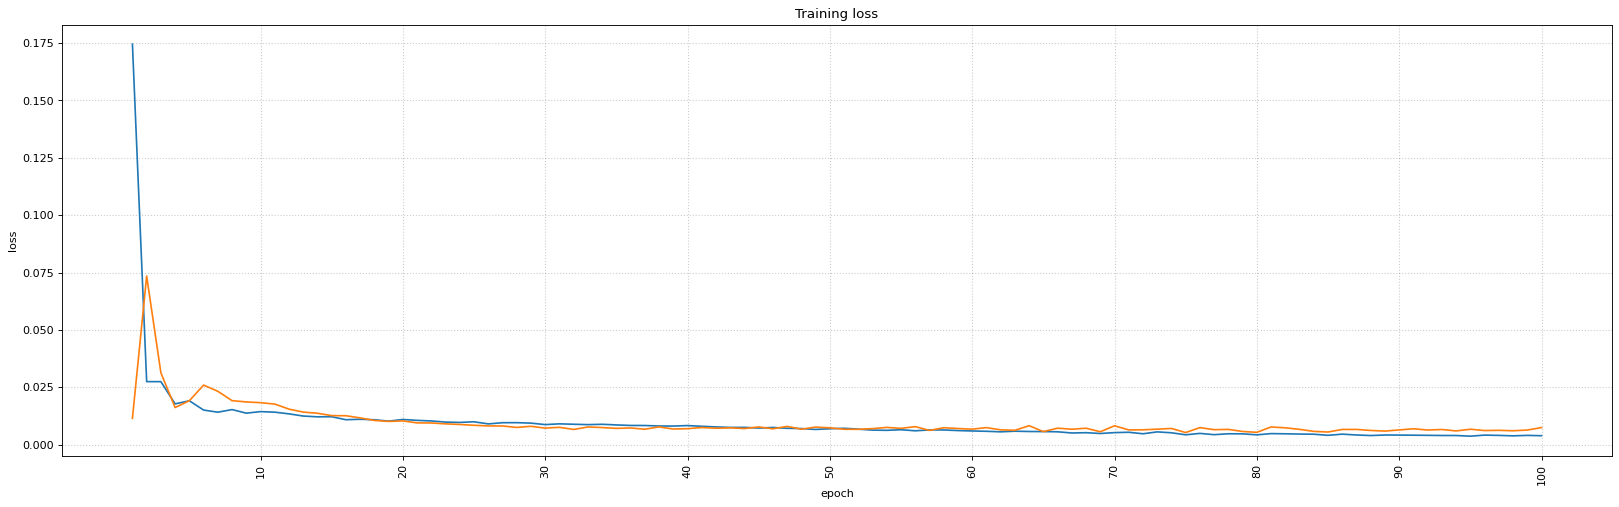

8/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:10:00.604477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:01.061700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:04.546578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:10.401336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:15.000934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:52.953322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:10:53.183920: I tensorflow/core/grappler/optimizers/cust

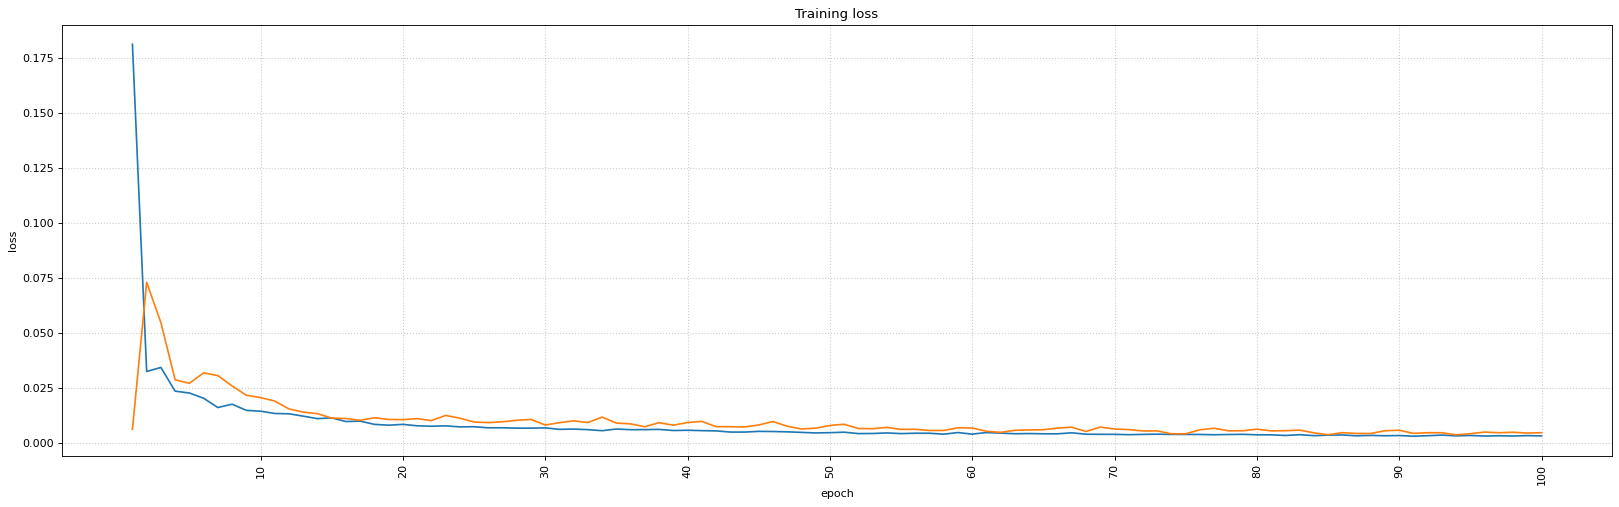

9/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:12:40.313517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:12:40.590651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:12:44.148767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:12:49.290749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:12:53.399456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:13:24.612693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:13:24.709338: I tensorflow/core/grappler/optimizers/cust

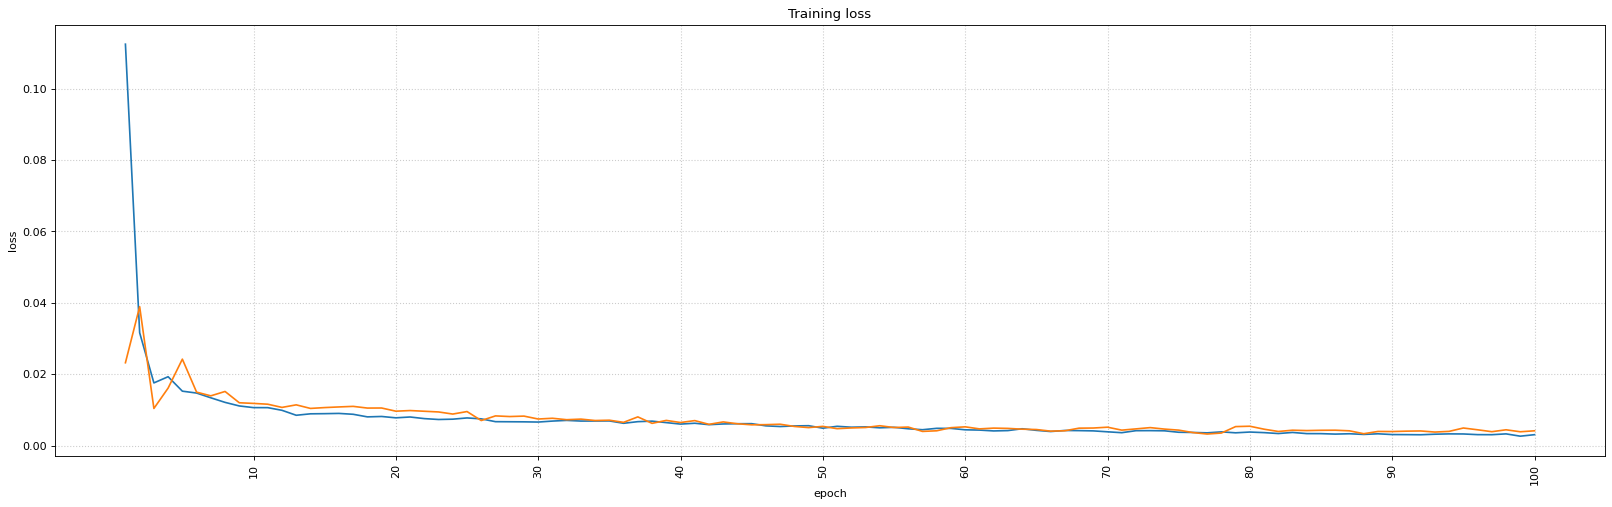

10/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 20:15:12.922221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:15:13.880503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:15:16.939293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:15:22.121279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:15:26.149414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:16:02.556025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:16:02.647181: I tensorflow/core/grappler/optimizers/cust

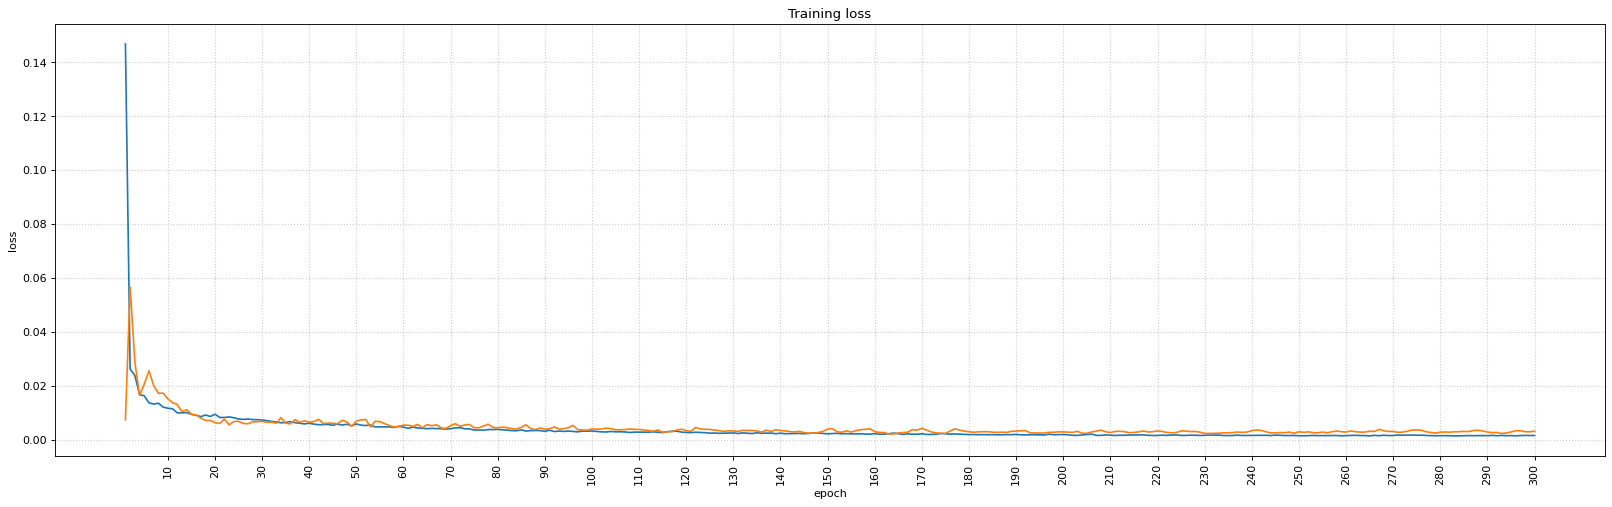

11/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 20:19:26.152711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:19:26.412610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:19:29.995285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:19:34.911814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:19:38.755133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:20:14.037170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:20:14.149755: I tensorflow/core/grappler/optimizers/cust

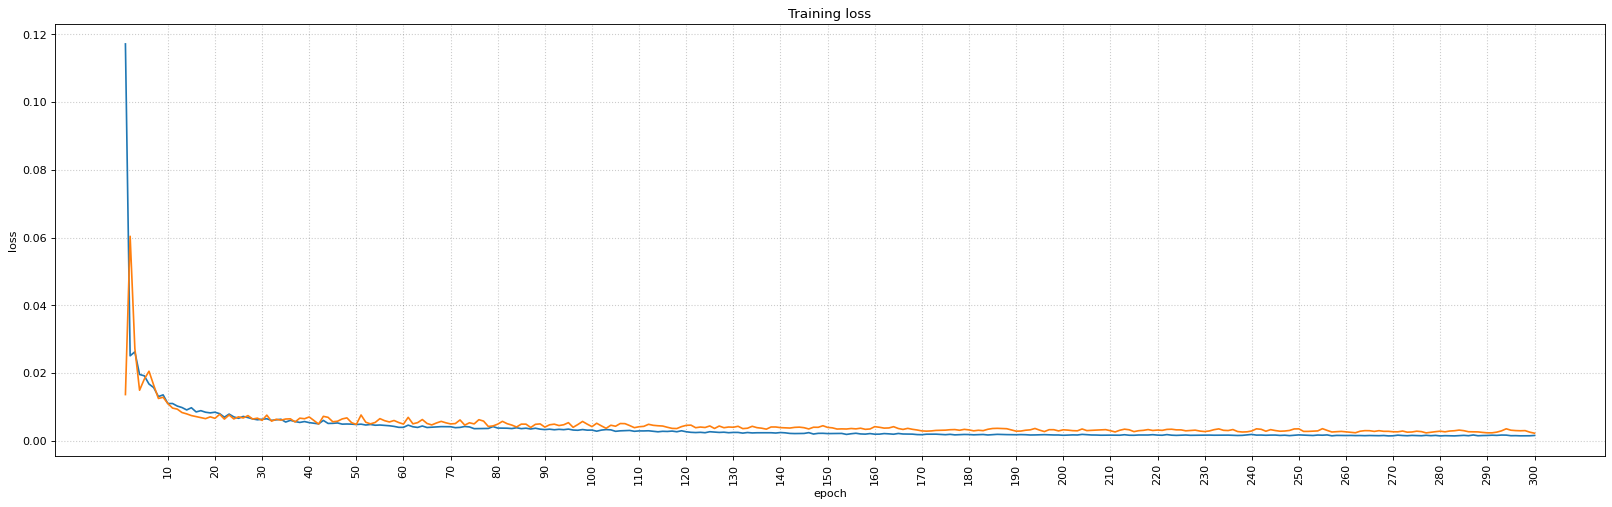

12/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 20:23:41.139229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:23:41.377961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:23:44.401320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:23:49.050567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:23:52.877166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:24:21.024373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:24:21.113344: I tensorflow/core/grappler/optimizers/cust

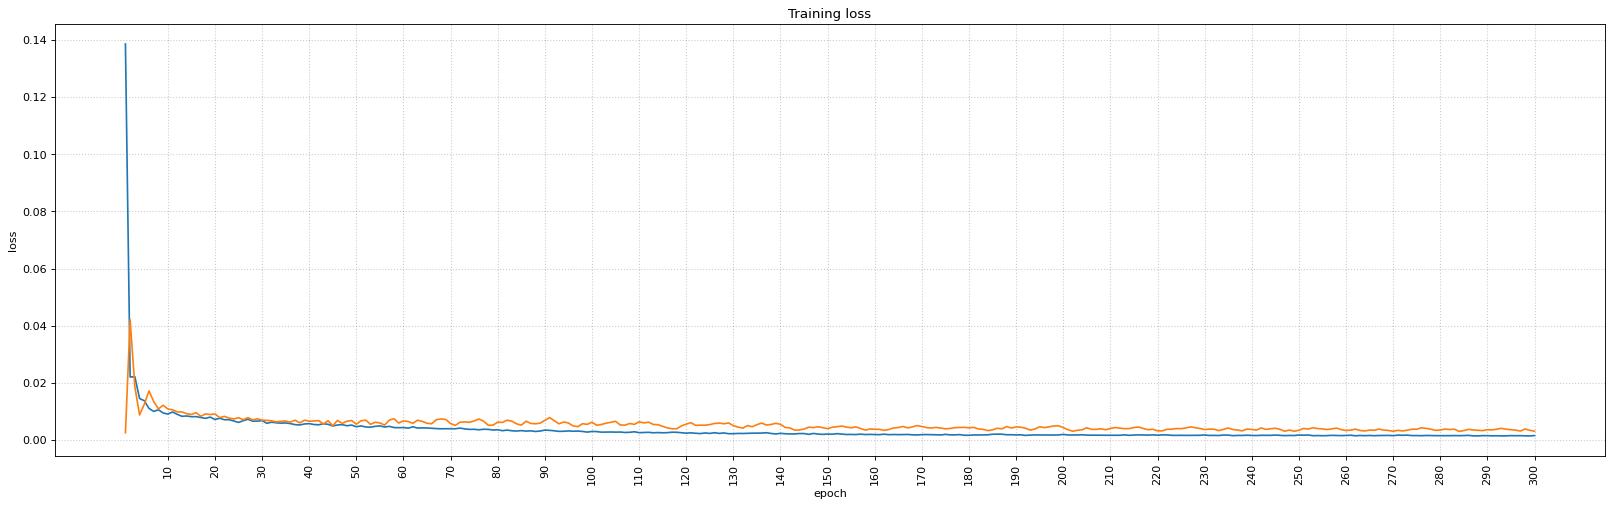

13/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 20:27:49.341907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:27:49.605132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:27:52.695207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:27:56.895087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:28:00.698936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:28:28.410378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:28:28.500334: I tensorflow/core/grappler/optimizers/cust

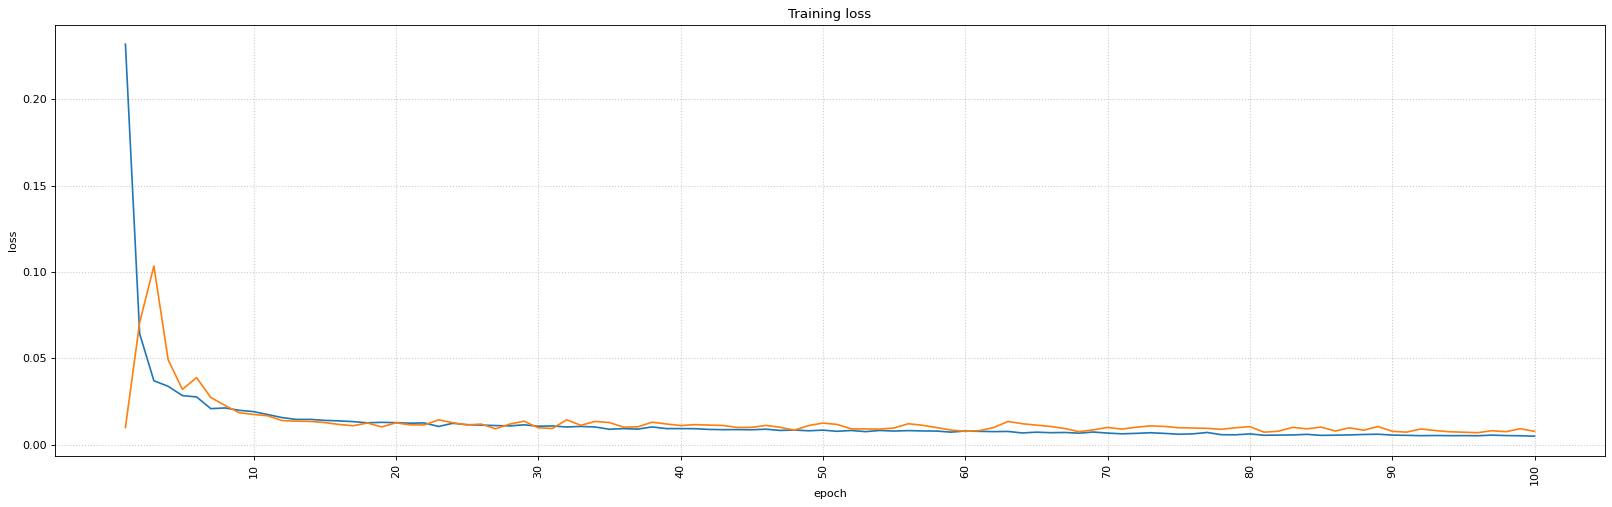

14/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 20:30:08.671377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:08.903070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:12.310357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:16.856670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:20.800829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:57.092373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:30:57.187566: I tensorflow/core/grappler/optimizers/cust

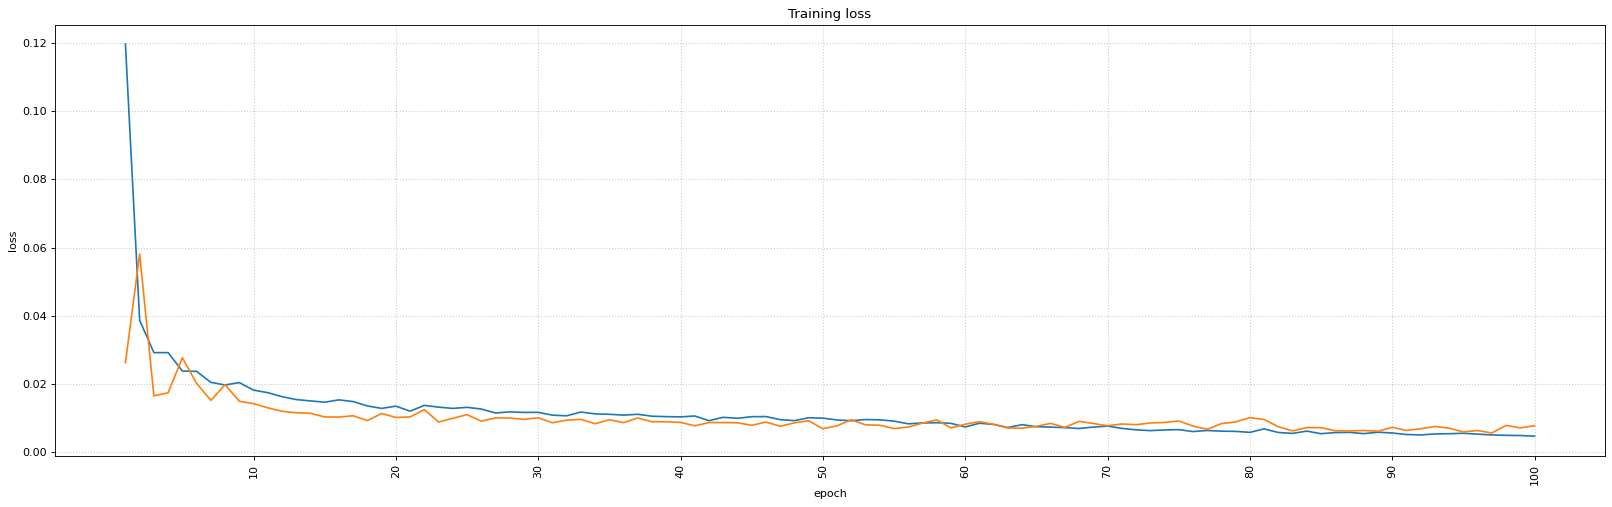

15/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 20:32:50.891881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:32:51.177759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:32:54.351649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:32:59.486767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:33:04.187167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:33:47.594671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:33:47.695834: I tensorflow/core/grappler/optimizers/cust

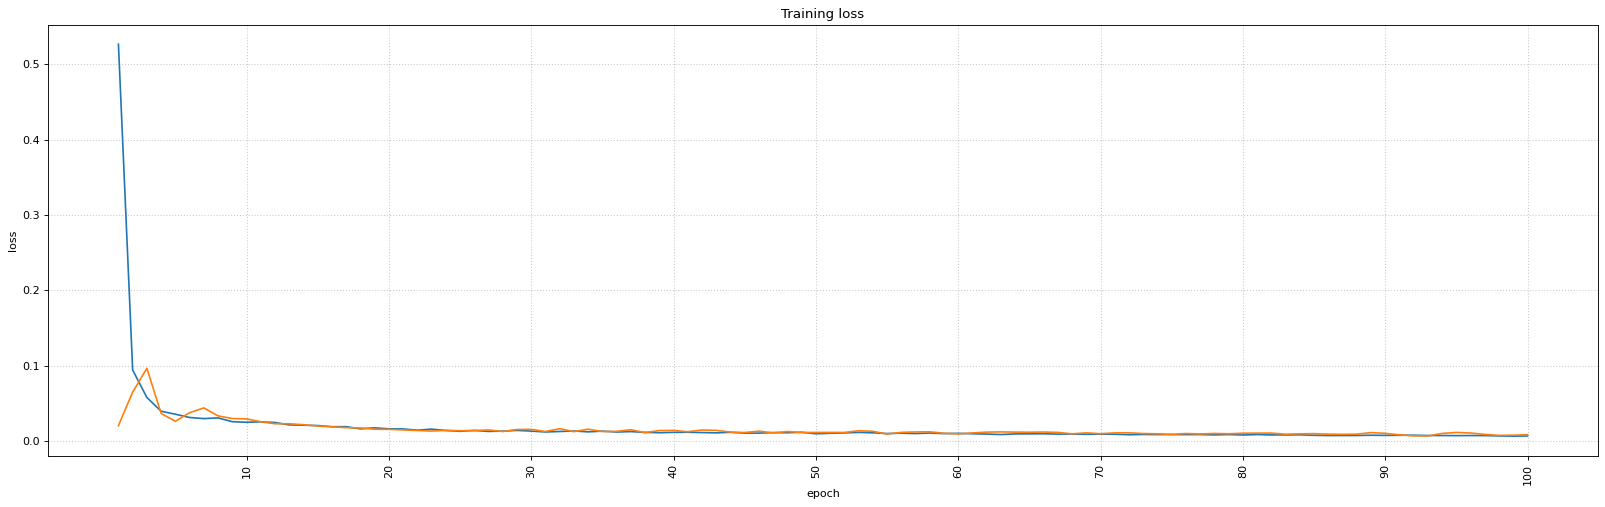

('AMZN', 90, 7, 0.1, 0.1, True) 90
16/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 20:35:38.018285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:35:38.275820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:35:42.264054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:35:47.281691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:35:51.480364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:36:27.596984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:36:27.713405: I tensorflow/core/grappler/optimizers/cust

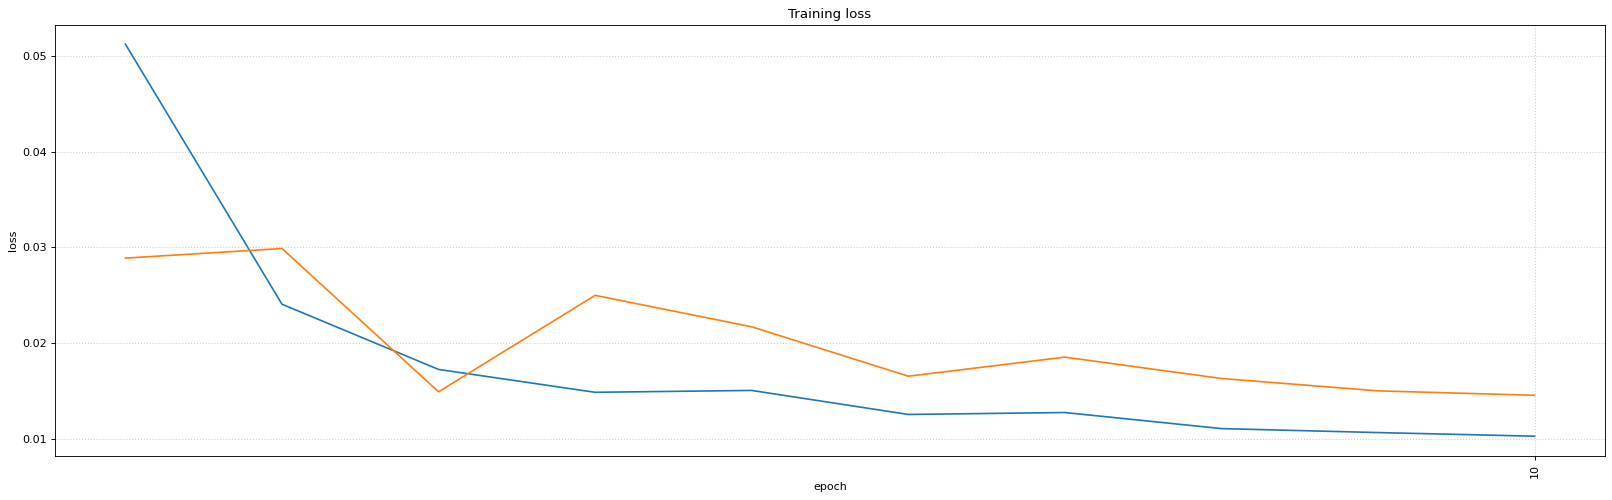

17/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 20:37:32.446385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:37:32.751034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:37:36.166461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:37:41.483209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:37:45.665701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:38:23.546115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:38:23.637210: I tensorflow/core/grappler/optimizers/cust

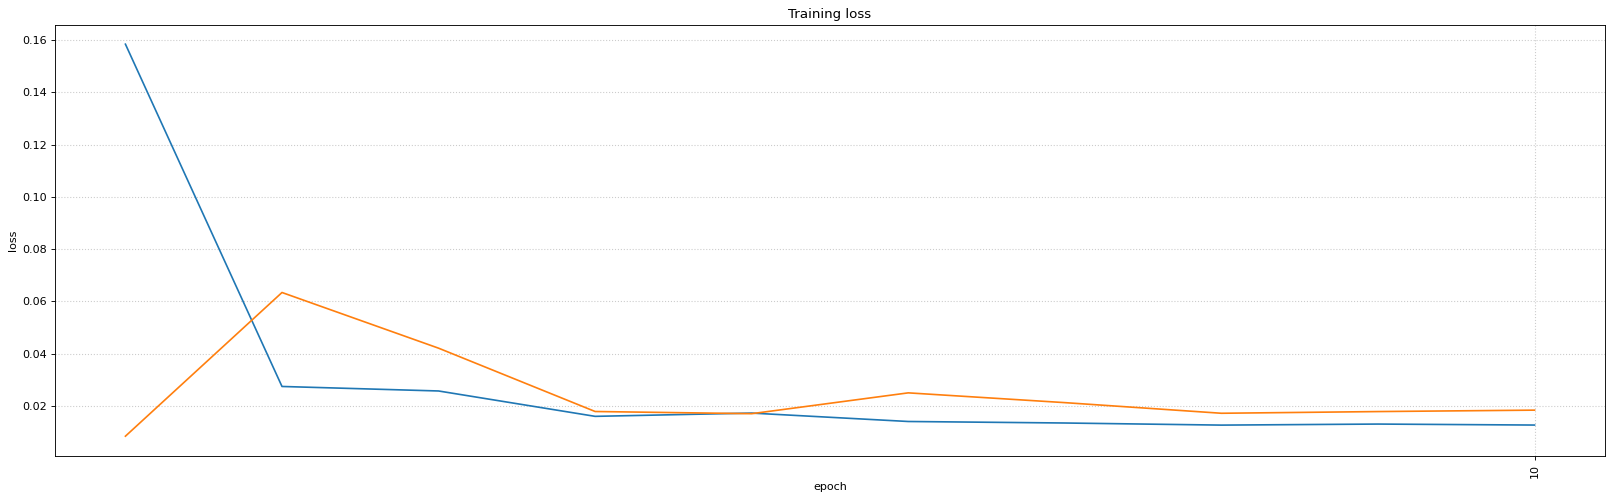

18/30 (10, 2, 16, 0.2, 'huber_loss', 'adam', 64) 10


2023-03-07 20:39:20.676953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:39:20.942777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:39:24.602420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:39:29.763239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:39:34.661115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:40:11.890305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:40:12.014121: I tensorflow/core/grappler/optimizers/cust

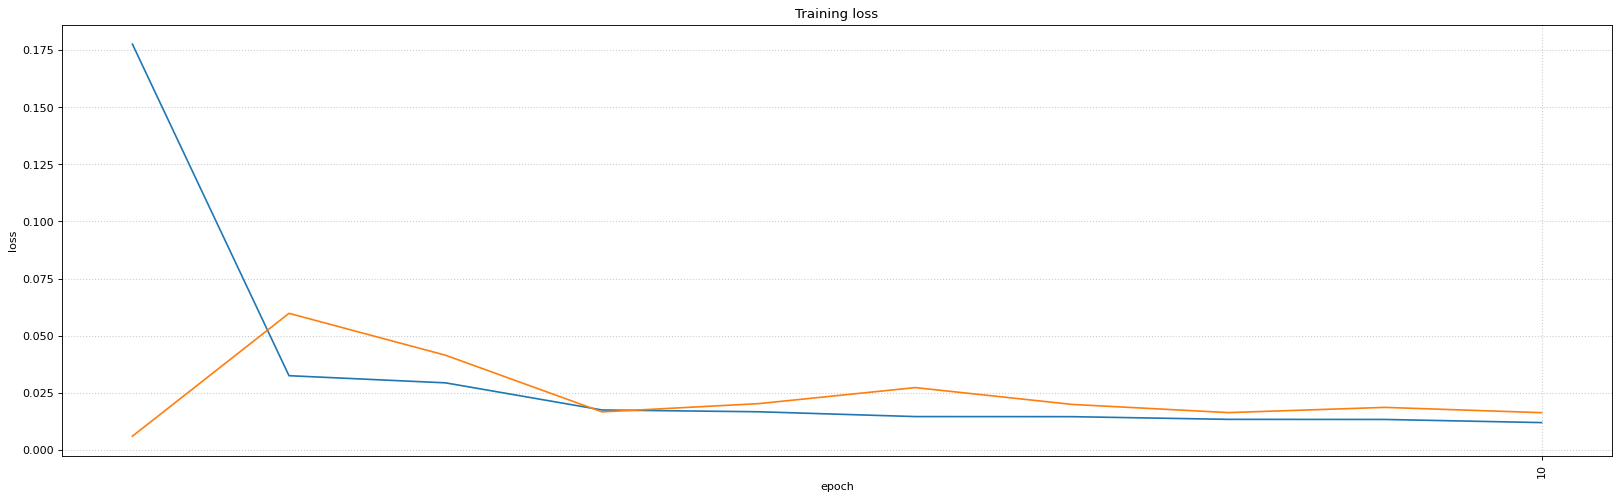

19/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:41:13.300537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:41:13.551839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:41:17.360300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:41:23.066621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:41:27.602360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:42:14.363526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:42:14.475190: I tensorflow/core/grappler/optimizers/cust

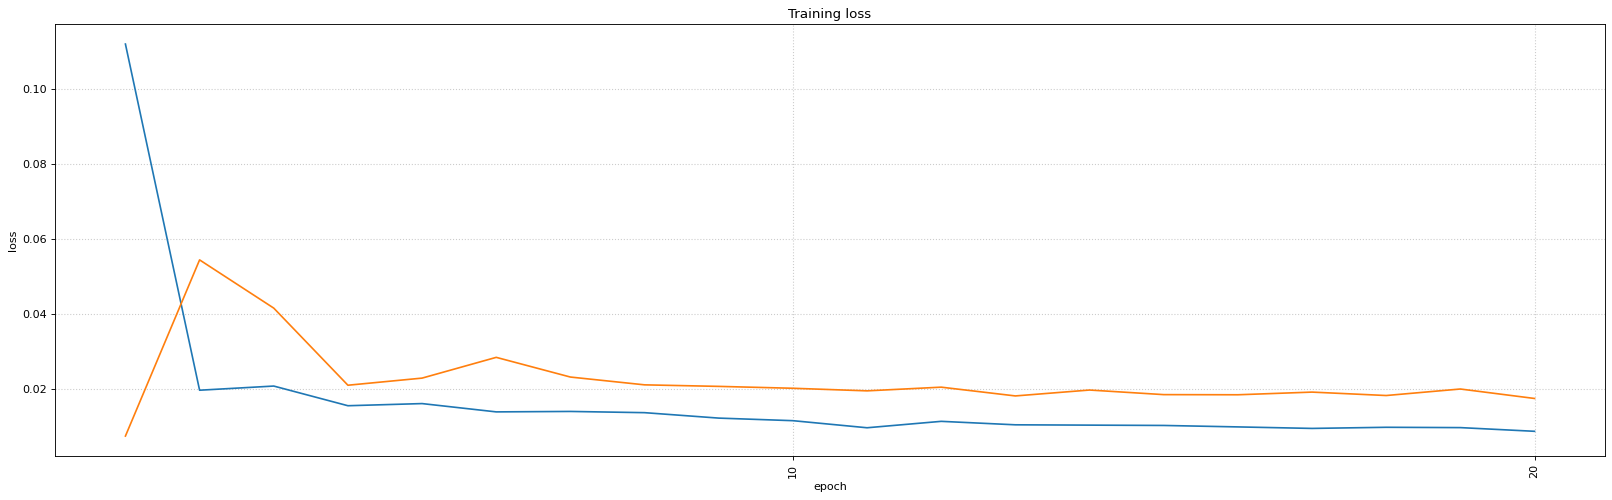

20/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:43:22.989628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:43:23.262042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:43:26.654877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:43:33.148246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:43:38.650872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:44:19.212444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:44:19.336156: I tensorflow/core/grappler/optimizers/cust

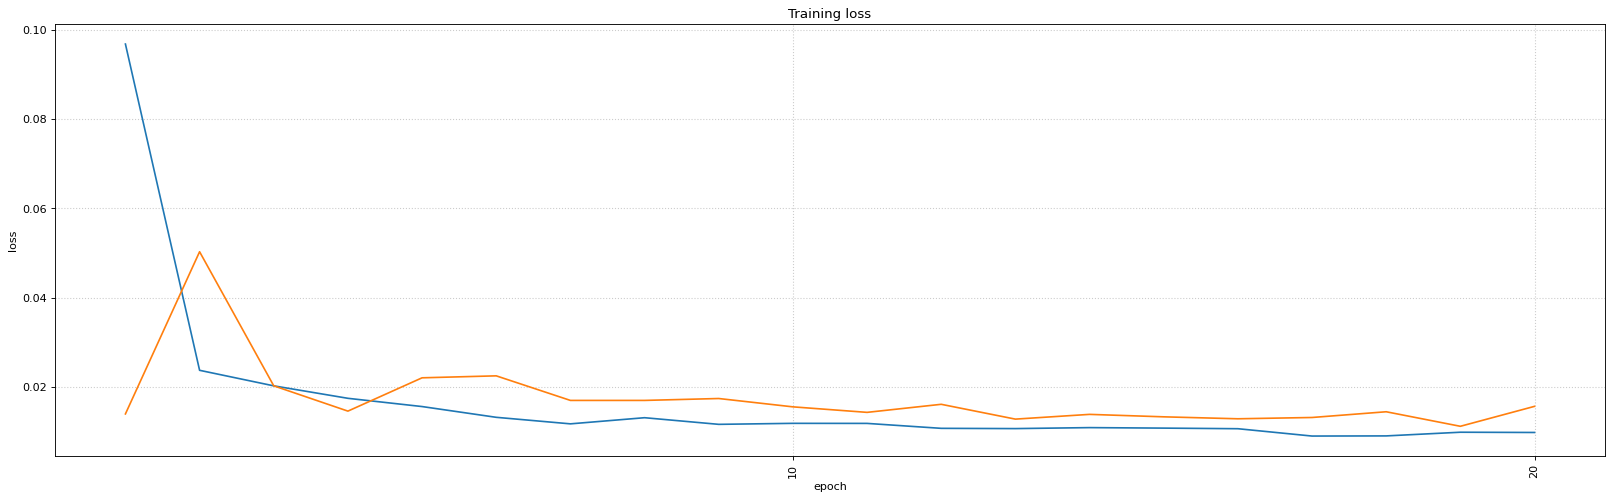

21/30 (20, 2, 16, 0.2, 'huber_loss', 'adam', 64) 20


2023-03-07 20:45:26.126465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:45:26.438650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:45:30.039533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:45:35.640779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:45:39.827621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:46:19.659799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:46:19.772302: I tensorflow/core/grappler/optimizers/cust

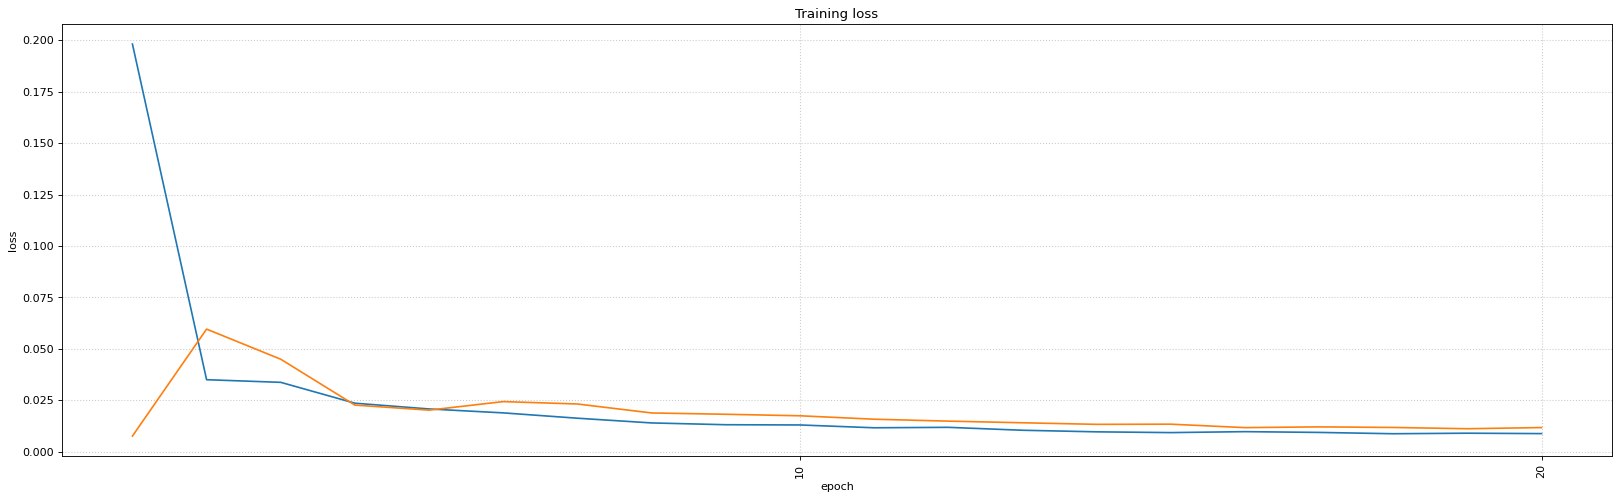

22/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:47:28.640117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:47:28.910312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:47:32.817604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:47:38.161503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:47:42.588386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:48:22.082435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:48:22.181292: I tensorflow/core/grappler/optimizers/cust

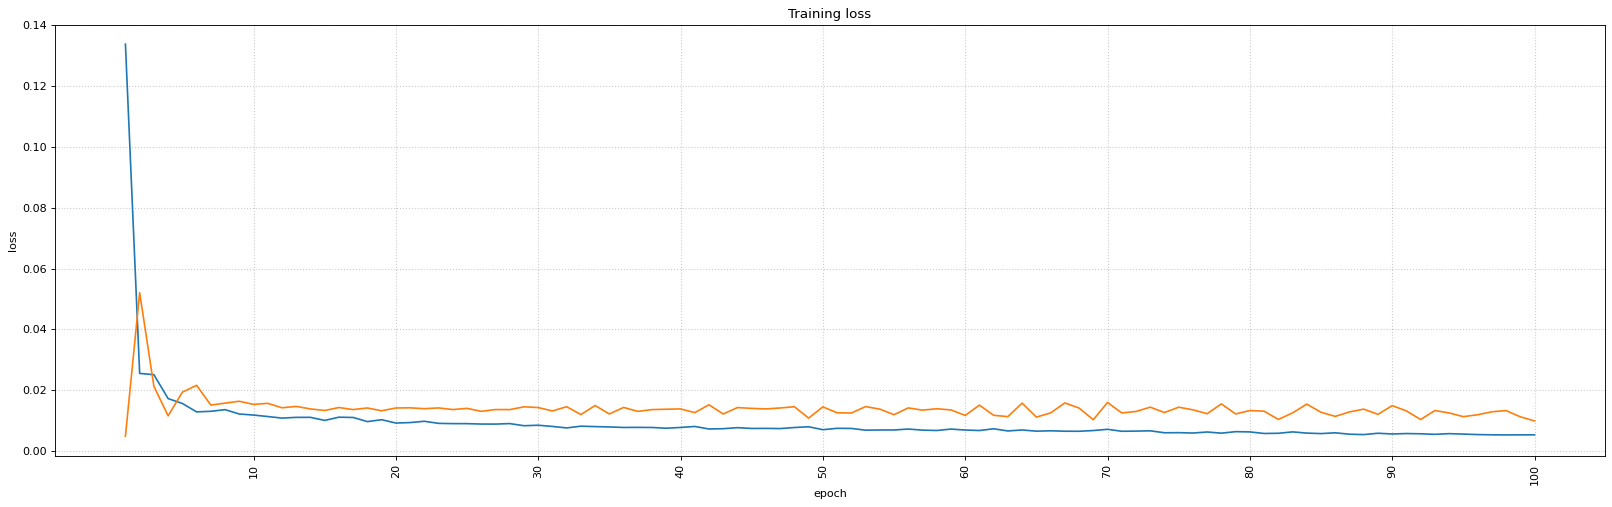

23/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:50:15.699130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:50:15.934097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:50:19.412144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:50:24.985559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:50:29.596450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:51:14.000275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:51:14.112131: I tensorflow/core/grappler/optimizers/cust

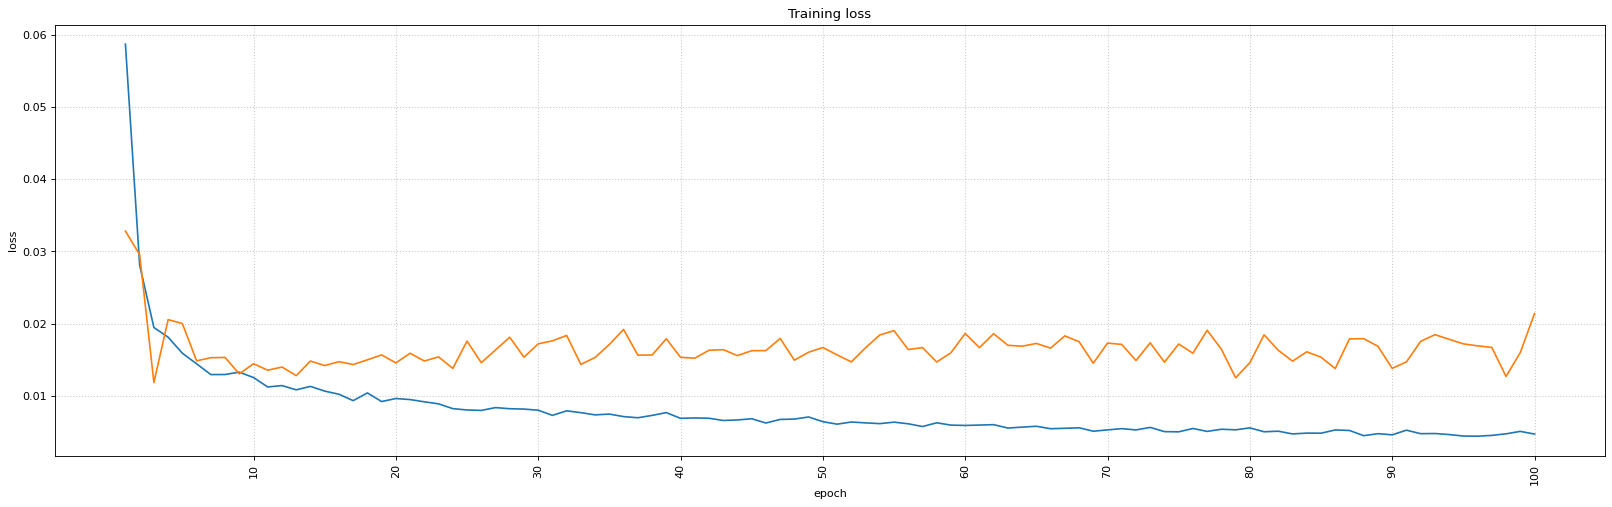

24/30 (100, 2, 16, 0.2, 'huber_loss', 'adam', 64) 100


2023-03-07 20:53:05.085919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:53:05.337353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:53:08.719443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:53:14.783942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:53:19.271167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:54:00.928510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:54:01.024878: I tensorflow/core/grappler/optimizers/cust

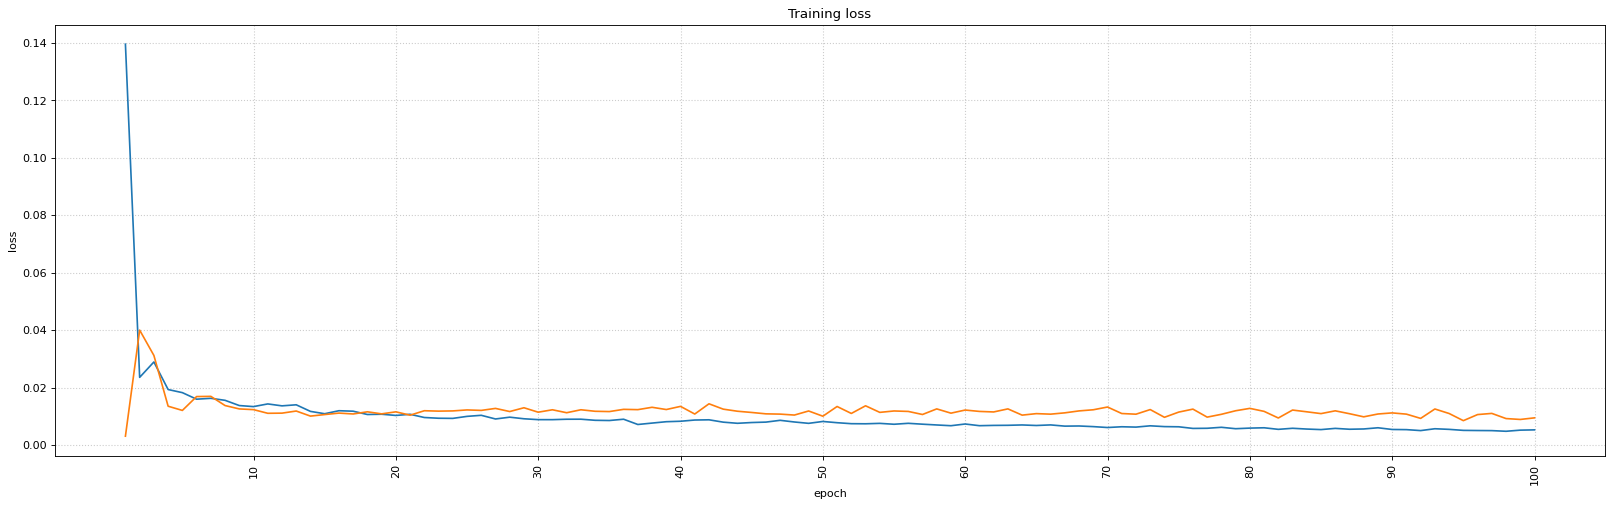

25/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 20:55:41.465679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:55:41.704938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:55:45.475250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:55:50.962721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:55:55.608929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:56:42.072927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 20:56:42.183618: I tensorflow/core/grappler/optimizers/cust

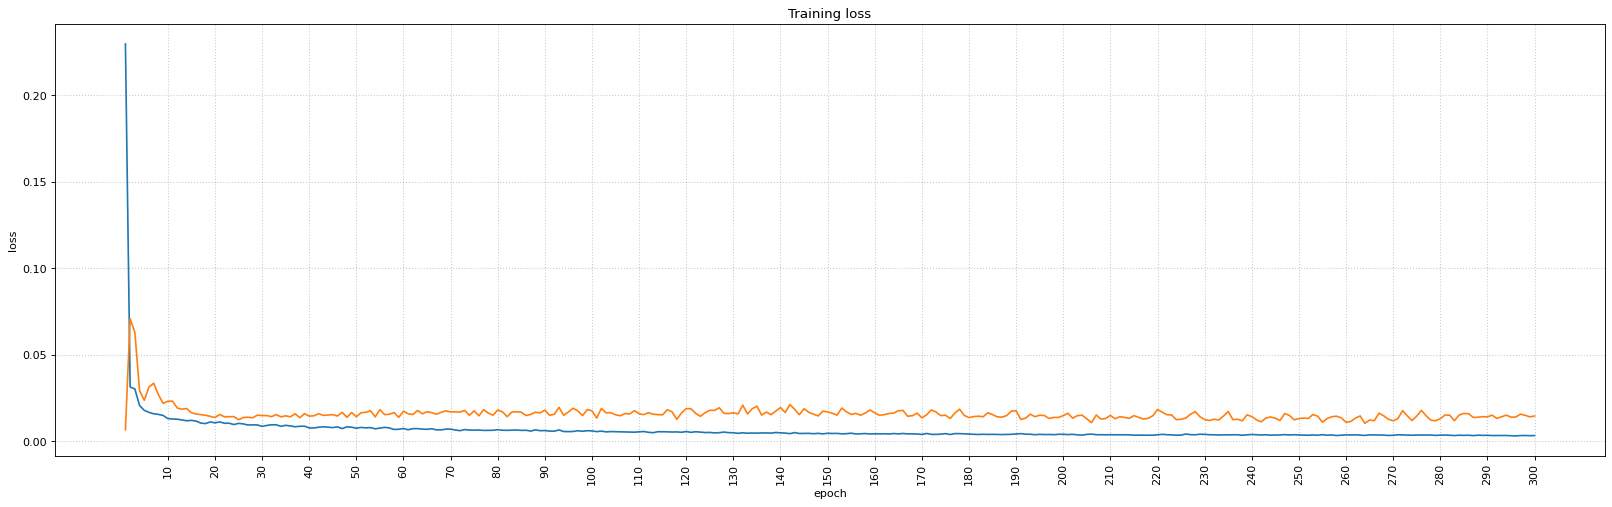

26/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 21:00:12.508805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:00:12.766647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:00:17.048846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:00:23.182042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:00:28.364043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:01:10.923241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:01:11.019251: I tensorflow/core/grappler/optimizers/cust

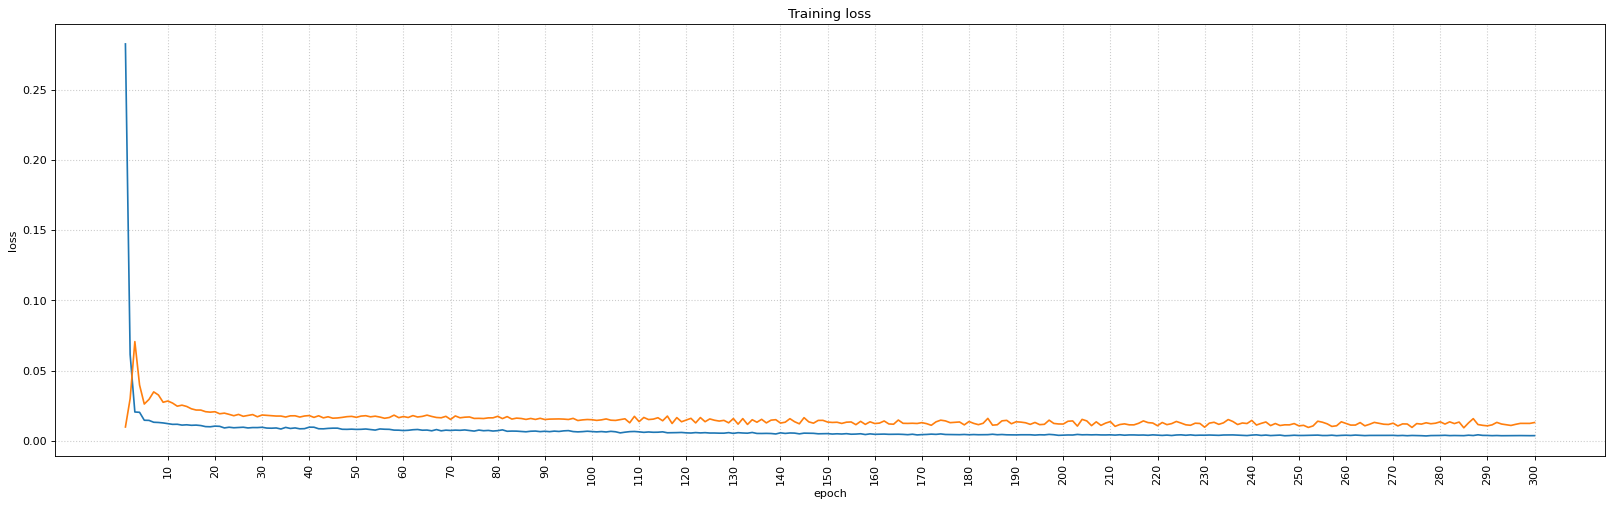

27/30 (300, 2, 16, 0.2, 'huber_loss', 'adam', 64) 300


2023-03-07 21:04:46.684854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:04:46.921721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:04:50.491731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:04:56.878345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:05:02.443016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:05:48.801014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:05:48.893419: I tensorflow/core/grappler/optimizers/cust

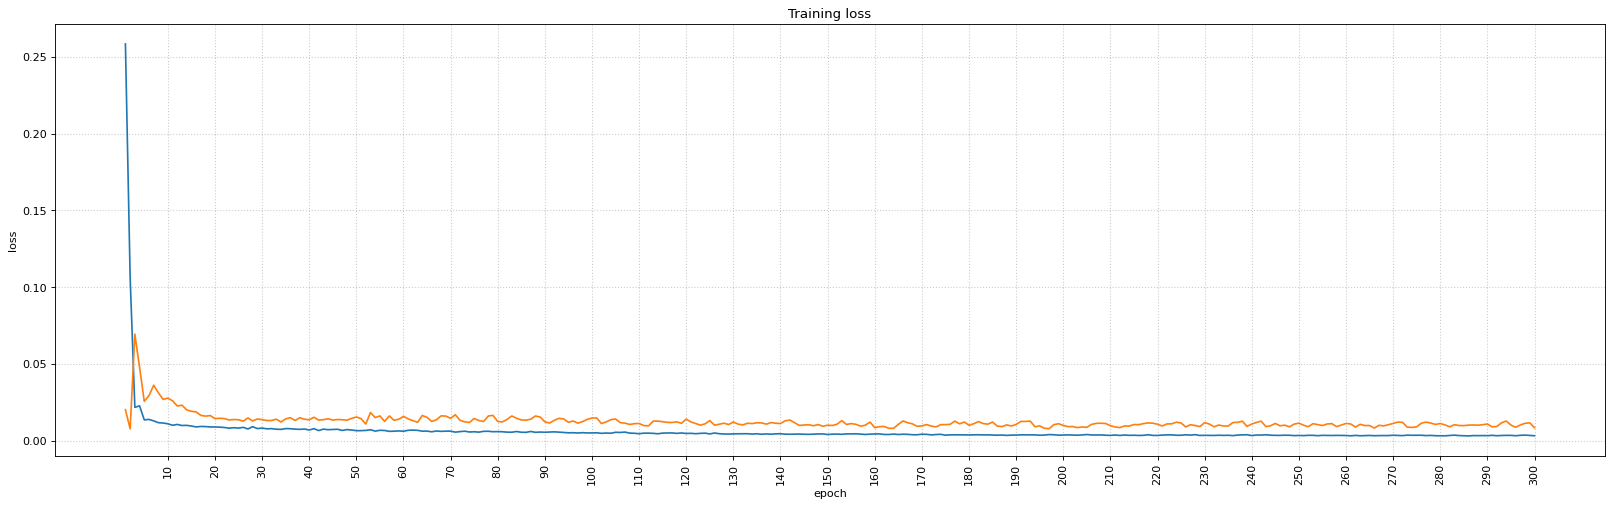

28/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 21:09:25.982155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:09:26.898384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:09:29.962384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:09:35.283349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:09:40.565130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:10:22.272789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:10:22.985014: I tensorflow/core/grappler/optimizers/cust

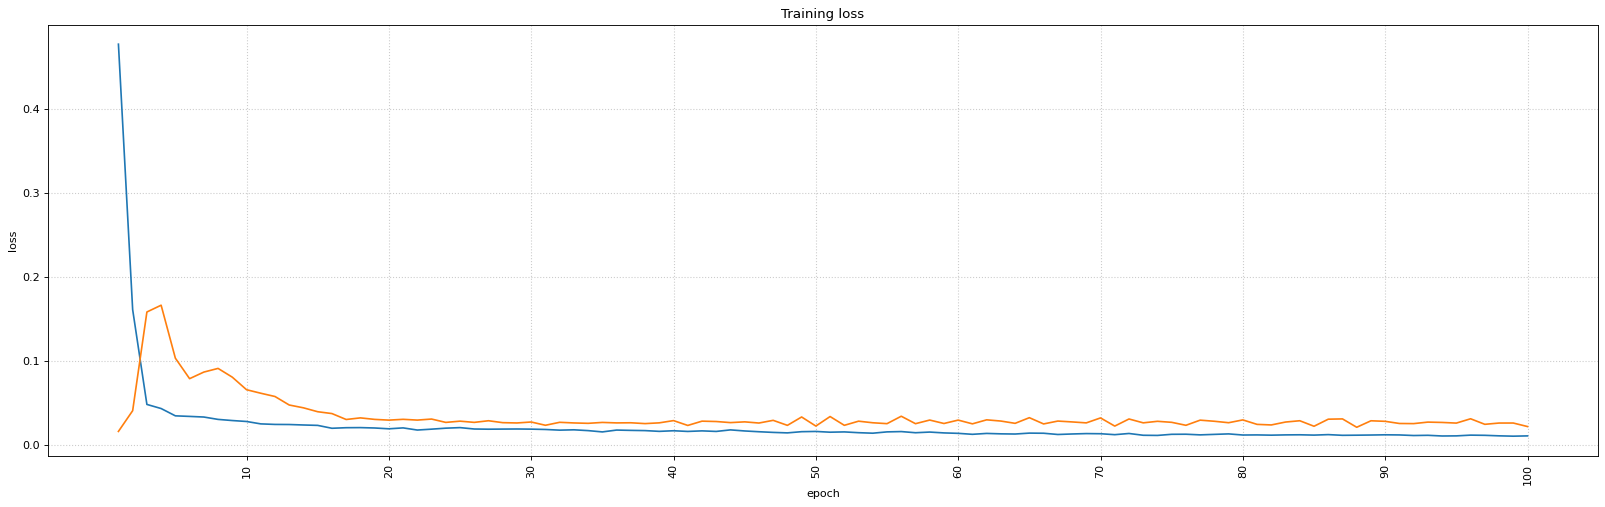

29/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 21:12:20.352565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:12:21.314434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:12:24.526717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:12:30.378352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:12:34.879862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:13:17.629996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:13:17.721182: I tensorflow/core/grappler/optimizers/cust

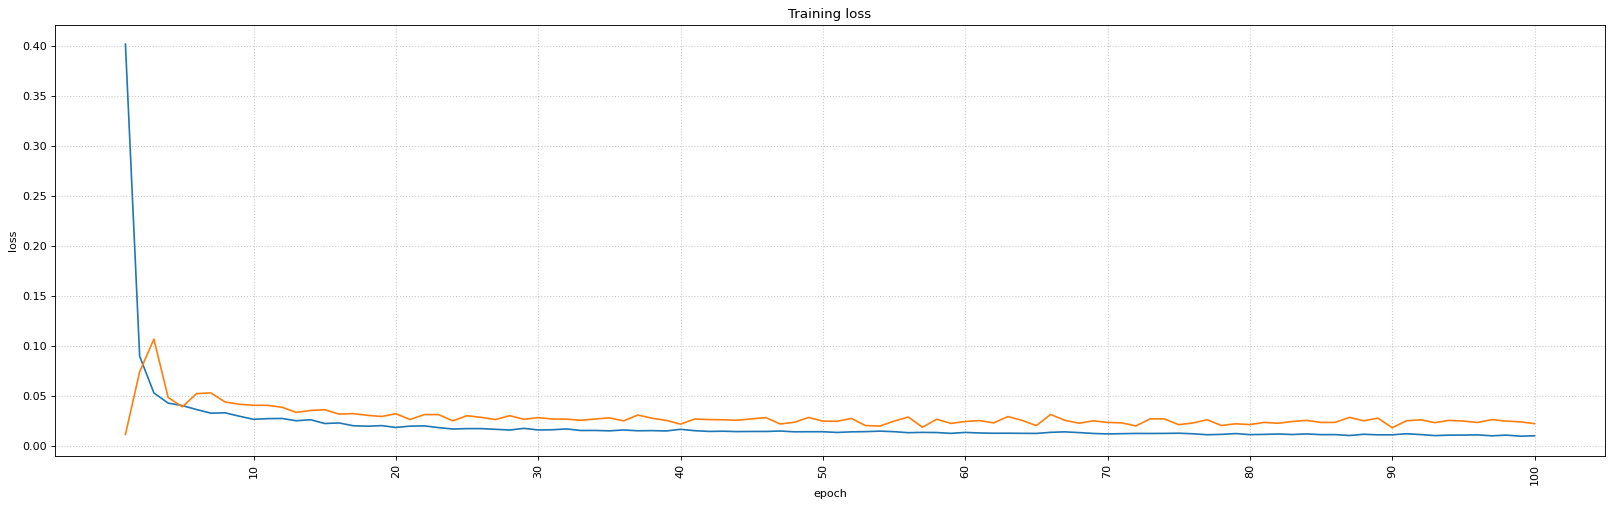

30/30 (100, 2, 16, 0.2, 'mse', 'adam', 64) 100


2023-03-07 21:15:13.333311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:15:13.570866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:15:17.030004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:15:21.687325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:15:26.077640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:16:07.721401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:16:07.813270: I tensorflow/core/grappler/optimizers/cust

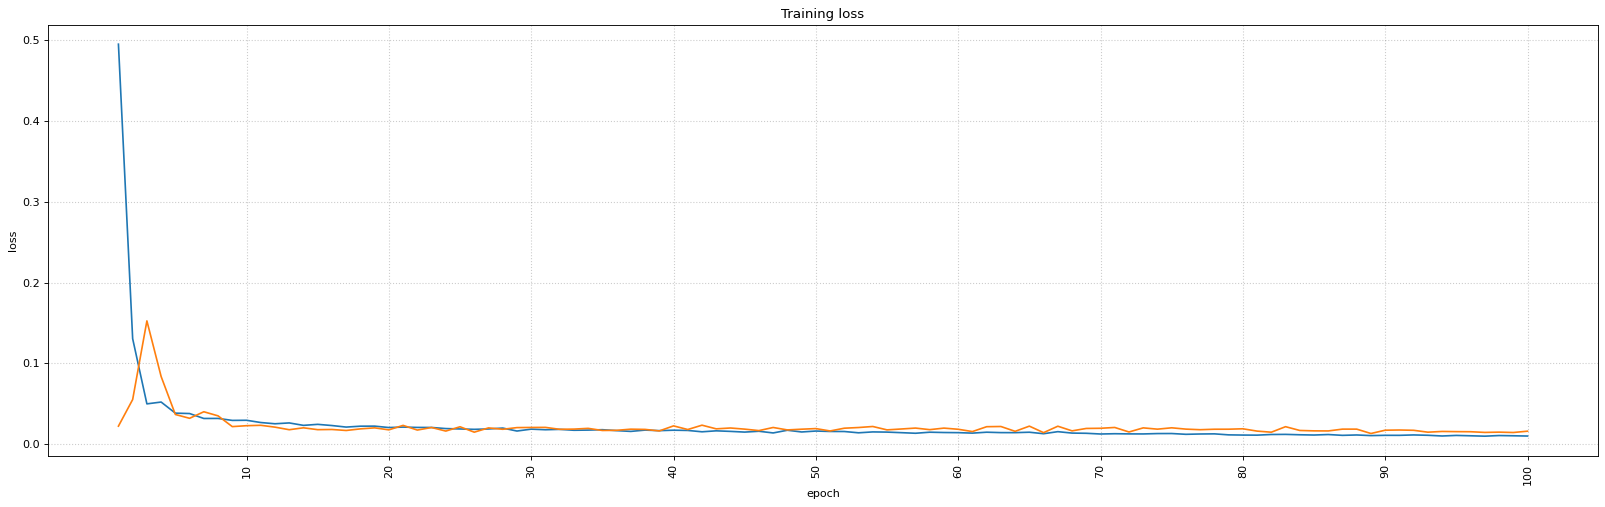

In [110]:
# Dataset settings
windows = [90] #[10, 30, 50, 70, 90]
tickers =  "AMZN".split(",") #"TSLA,AMZN,AAPL,NVDA,AMD".split(",")
lookaheads = [2, 7]
validations = [0.1]
tests = [0.1]
scaled = [True]

# Comparison options
epochs = [100, 300, 500] # [10, 50, 100, 200, 400]
layers = [2, 4, 7] # [2, 3, 4, 5]
num_neurons = [4, 16, 32] # [16, 32, 64, 256]
dropouts = [0.2, 0.3] # [0.2, 0.3, 0.4] # 0.2 to 0.5 the higher the more the network will underfit
loss_functions = ['huber_loss'] # 'huber_loss', 'mse', 'mae', 'huber', 'log_cosh', 'mean_squared_logarithmic_error'
optimizers = ['adam'] # ['rmsprop', 'adam'] 'rmsprop', 'adam', 'adagrad', 'nadam', 'adadelta'
batch_size = [64]
# Simpler comparative options
network_combinations = [(10, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (10, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (10, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (20, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (20, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (20, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (100, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (100, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (100, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (300, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (300, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (300, 2, 16, 0.2, 'huber_loss', 'adam', 64),
                        (100, 2, 16, 0.2, 'mse', 'adam', 64),
                        (100, 2, 16, 0.2, 'mse', 'adam', 64),
                        (100, 2, 16, 0.2, 'mse', 'adam', 64),
                        ]

import itertools
# download all the different data
stocks = {}
for ticker in tickers:
    print(ticker)
    stocks[ticker] = getData(ticker, config["data"]["offset"])
print()

# prepare data to be used for the different 
datasets = {}
for opts in itertools.product(tickers, windows, lookaheads, validations, tests, scaled):
    # print(opts)
    # process the data with all of the settings
    datasets[opts] = setupData(stocks[opts[0]], opts[1], opts[2], opts[3], opts[4], opts[5], config["data"]["scaler"], config["data"]["inputs"])
    # datasets[opts] = 1024
print()

# find out how many total networks are being trained
total = 0
for dataset in datasets:
    for opts in network_combinations:
    # for opts in itertools.product(epochs, layers, num_neurons, dropouts, loss_functions, optimizers, batch_size):
        total += 1

# setup different models
current = 0
combinations = [] # setup a list with all the differnet networks
for dataset in datasets:
    # create all the different networks
    print(dataset, dataset[1])
    nets = {}
    for idx, opts in enumerate(network_combinations):
    # for opts in itertools.product(epochs, layers, num_neurons, dropouts, loss_functions, optimizers, batch_size):
        current += 1
        print(f'{current}/{total}', opts, opts[0])
        # create a model (window, number_of_layers, neurons, ...)
        model = generateModel(dataset[1], opts[1], opts[2], n_features= config["nn"]["nFeatures"], dropout= opts[3], loss= opts[4], optimizer= opts[5], layerType= config["nn"]["layerType"])
        # train the model on the dataset (verbose has been set to 0)
        history = model.fit(datasets[dataset]["xtrain"], datasets[dataset]["ytrain"], batch_size= opts[6], epochs= opts[0], validation_data=(datasets[dataset]["xval"], datasets[dataset]["yval"]), verbose=0)

        train_history = pd.DataFrame(history.history)
        fig = plt.figure(figsize=(25, 7), dpi=80)
        plt.plot(range(1,opts[0]+1), train_history['loss'])
        plt.plot(range(1,opts[0]+1), train_history['val_loss'])
        # train_history.plot(figsize=(20,7))
        plt.title('Training loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.xticks(range(10,opts[0]+1,10), rotation='vertical') 
        plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
        plt.show()

        # save the model
        nets[idx, opts] = model
    # store all the trained networks and their dataest in a dictionary
    comb = {}
    comb["dataset"] = dataset # only save the name of the dataset used (it can be called from datasets at any point)
    comb["networks"] = nets
    # add the combination to the combinations
    combinations.append(comb)



Analysis of results

In [111]:
# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
def calculate_krr(_data, _scaled):
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(_data['xtrain'][:, -1, :], _data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(_data['xtest'][:, -1, :])
    if _scaled:
        pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))
    return pred_krr
# Simple Moving Average
def calculate_ma(_data, _scaled):
    # calcualte the price using a simple moving average
    pred_ma = np.mean(_data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    if _scaled:
        pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))
    return pred_ma
# Exponentila Moving Average
def calculate_ema(_data, _scaled, _window):
    # calculate the price using exponential moving average
    pred_ema = _data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, _window))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    if _scaled:
        pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))
    return pred_ema

# GET RESULTS FROM ALL THE NETWORKS
section = "test" #train, val, test
# ^^^^^ COULD BE WORKED ON NEXT
for comb in combinations:
    data = datasets[comb["dataset"]]
    # copmare each network against each other
    predictions = {}
    y = data["ytest"]

    # if scaled
    if comb['dataset'][5]:
        y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))
# needs to be updated

    for net in comb["networks"]:
        model = comb["networks"][net]
        # for the training
        predictions[net] = model.predict(data["xtest"])


        # if the data is scaled
        if comb['dataset'][5]:
            predictions[net] = np.squeeze(config["data"]["scaler"].inverse_transform(model.predict(data["xtest"])))
 # needs to be updated

    if 1:
        # add the other methods to compare against
        predictions["krr"] = calculate_krr(data, comb['dataset'][5])
        predictions["ma"] = calculate_ma(data, comb['dataset'][5])
        predictions["ema"] = calculate_ema(data, comb['dataset'][5], comb["dataset"][1])

    comb["predictions"] = predictions

    # plot_predictions(data["testDates"], y, predictions, section, comb['dataset'])
    # calc_stats(y, predictions, comb["networks"])
    # store the predictions made
    # break

2023-03-07 21:21:01.063177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:01.179731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:03.231232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 879ms/step


2023-03-07 21:21:12.761895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:12.860301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:14.987573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 1s/step


2023-03-07 21:21:25.237580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:25.316364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:27.292959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 1s/step


2023-03-07 21:21:35.493775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:35.574814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:37.029331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 450ms/step


2023-03-07 21:21:43.370341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:43.448852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:44.913622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 2s/step


2023-03-07 21:21:54.233190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:54.311055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:21:56.306350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 584ms/step


2023-03-07 21:22:03.251630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:03.328272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:04.758407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 699ms/step


2023-03-07 21:22:10.940892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:11.050605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:12.949507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 1s/step


2023-03-07 21:22:20.823311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:20.904251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:22.789340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 343ms/step


2023-03-07 21:22:29.672350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:29.758564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:31.834050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 324ms/step


2023-03-07 21:22:39.336742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:39.412799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:41.406398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 876ms/step


2023-03-07 21:22:49.808864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:49.906446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:22:51.366716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 802ms/step


2023-03-07 21:23:00.382876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:00.484231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:02.408889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 564ms/step


2023-03-07 21:23:11.681866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:11.785659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:13.754815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 869ms/step


2023-03-07 21:23:22.339740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:22.418966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:23.848746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 1s/step


2023-03-07 21:23:33.635196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:33.715241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:35.206514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 922ms/step


2023-03-07 21:23:45.478641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:45.578951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:47.587491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 1s/step


2023-03-07 21:23:56.676515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:56.768264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:23:58.208429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 312ms/step


2023-03-07 21:24:04.770657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:04.853279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:06.861012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 323ms/step


2023-03-07 21:24:13.123197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:13.199134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:14.645709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 851ms/step


2023-03-07 21:24:22.245613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:22.341271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:24.284335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 177ms/step


2023-03-07 21:24:32.308785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:32.390064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:34.170847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 738ms/step


2023-03-07 21:24:41.909492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:41.993584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:43.867658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 1s/step


2023-03-07 21:24:52.286897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:52.370996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:24:54.318273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 985ms/step


2023-03-07 21:25:03.803153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:03.885308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:05.863999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 773ms/step


2023-03-07 21:25:14.361429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:14.457081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:16.472191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 1s/step


2023-03-07 21:25:25.396239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:25.479808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:26.976524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 428ms/step


2023-03-07 21:25:33.808358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:33.887685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:35.807722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 1s/step


2023-03-07 21:25:43.788019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:43.864266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:45.965269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 357ms/step


2023-03-07 21:25:52.578538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:52.658547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 21:25:54.860532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 601ms/step


Display the results

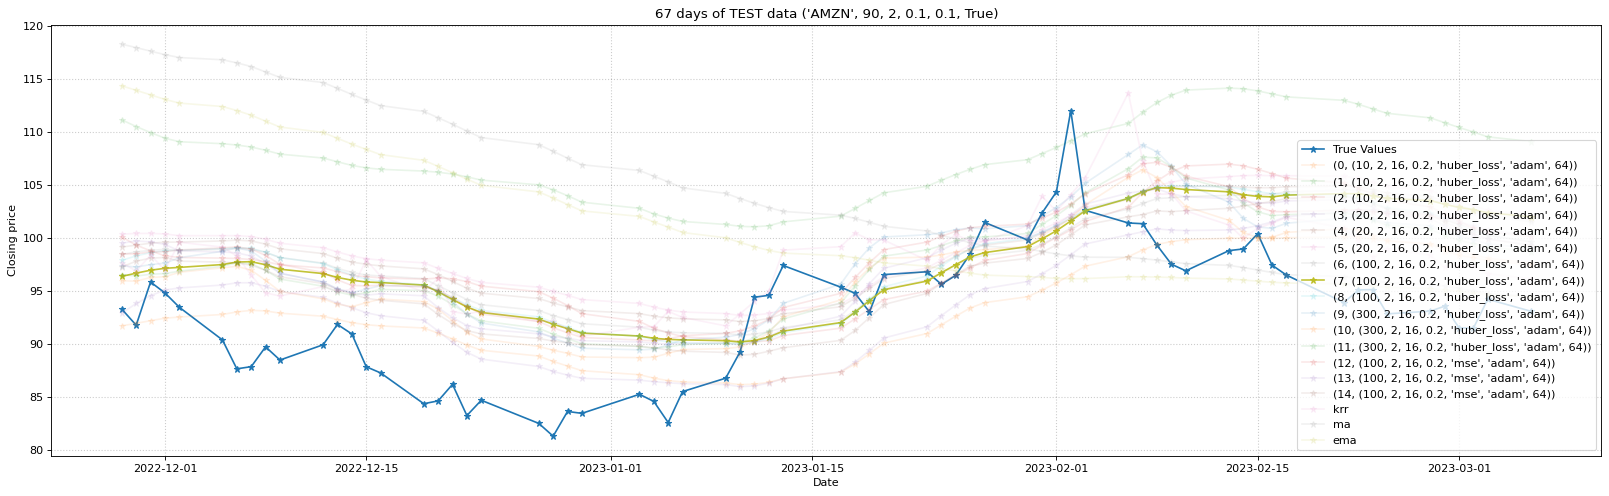

net0 - (0, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net1 - (1, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net2 - (2, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net3 - (3, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net4 - (4, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net5 - (5, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net6 - (6, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net7 - (7, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net8 - (8, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net9 - (9, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net10 - (10, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net11 - (11, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net12 - (12, (100, 2, 16, 0.2, 'mse', 'adam', 64))
net13 - (13, (100, 2, 16, 0.2, 'mse', 'adam', 64))
net14 - (14, (100, 2, 16, 0.2, 'mse', 'adam', 64))


net0        net1       net2       net3       net4       net5  \
MSE   27.964037  249.139501  57.877607  33.084729  61.617740  70.693014   
RMSE   5.288103   15.784153   7.607733   5.751933   7.849697   8.407914   
MAE    4.520039   14.848320   6.743318   4.945327   6.855482   7.354594   
MAPE   4.849842   16.343445   7.412988   5.328260   7.577776   8.133437   
DA     0.469697    0.515152   0.530303   0.515152   0.424242   0.530303   
R²     0.278737   -5.425935  -0.492809   0.146662  -0.589277  -0.823351   

           net6       net7       net8       net9      net10      net11  \
MSE   53.134868  47.230257  47.506630  40.190661  26.764794  37.346313   
RMSE   7.289367   6.872427   6.892505   6.339610   5.173470   6.111163   
MAE    6.405447   5.994871   6.080531   5.656001   4.511919   5.426894   
MAPE   7.056481   6.591605   6.690566   6.211618   4.954487   5.957661   
DA     0.484848   0.469697   0.469697   0.469697   0.454545   0.484848   
R²    -0.370482  -0.218187  -0.225316  -0.036618   0.309669   0.036745   

          net12      net13      net14        krr          ma         ema  
MSE   45.833068  39.807957  37.513165  37.793982  275.767784  187.347522  
RMSE   6.770012   6.309355   6.124799   6.147681   16.606257   13.687495  
MAE    6.081451   5.647499   5.419866   5.351179   12.724616   10.543347  
MAPE   6.685052   6.196263   5.928043   5.917446   14.321399   11.820022  
DA     0.500000   0.500000   0.515152   0.439394    0.515152    0.484848  
R²    -0.182150  -0.026747   0.032441   0.025198   -6.112746   -3.832164

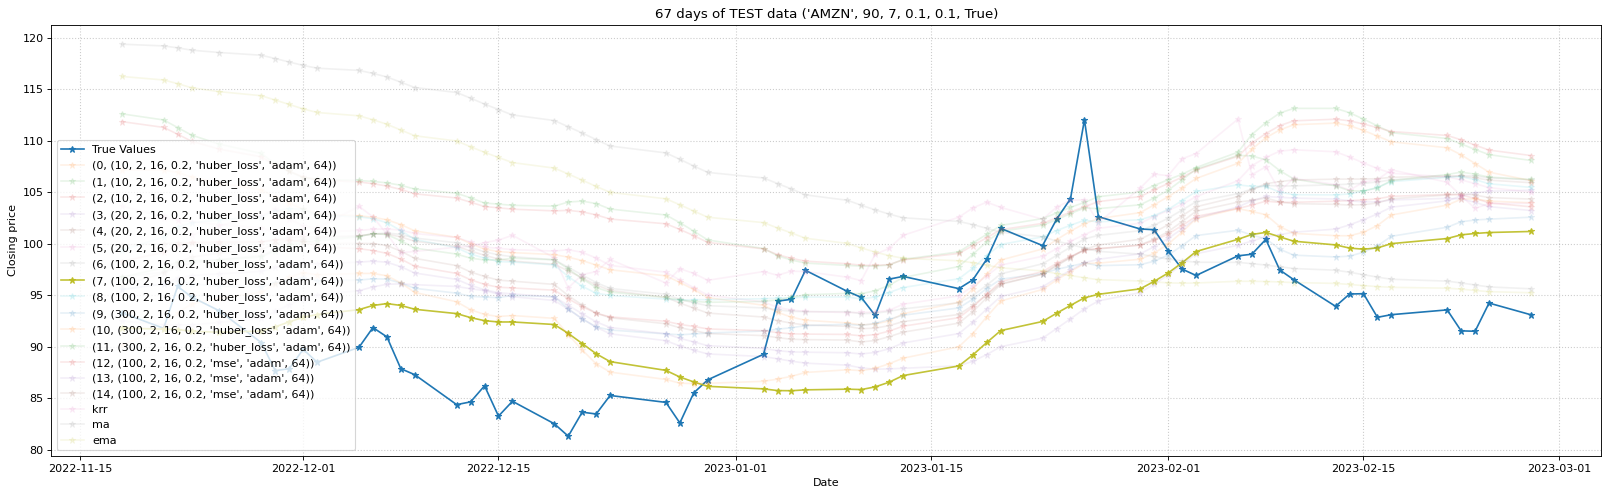

net0 - (0, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net1 - (1, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net2 - (2, (10, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net3 - (3, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net4 - (4, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net5 - (5, (20, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net6 - (6, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net7 - (7, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net8 - (8, (100, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net9 - (9, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net10 - (10, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net11 - (11, (300, 2, 16, 0.2, 'huber_loss', 'adam', 64))
net12 - (12, (100, 2, 16, 0.2, 'mse', 'adam', 64))
net13 - (13, (100, 2, 16, 0.2, 'mse', 'adam', 64))
net14 - (14, (100, 2, 16, 0.2, 'mse', 'adam', 64))


net0        net1        net2       net3       net4        net5  \
MSE   138.186515  211.383260  201.484846  63.733252  93.291812  110.561845   
RMSE   11.755276   14.539025   14.194536   7.983311   9.658769   10.514839   
MAE    10.301689   12.768458   12.452311   6.991458   8.546970    9.114427   
MAPE   11.372792   14.168860   13.820133   7.576942   9.443976   10.106691   
DA      0.500000    0.500000    0.500000   0.484848   0.575758    0.484848   
R²     -2.564178   -4.452107   -4.196802  -0.643841  -1.406231   -1.851668   

           net6       net7       net8       net9      net10      net11  \
MSE   90.337529  45.462972  94.760373  42.635324  48.748252  89.804232   
RMSE   9.504606   6.742623   9.734494   6.529573   6.981995   9.476509   
MAE    8.123088   5.873793   8.253257   5.599654   6.214721   8.042795   
MAPE   9.013294   6.310582   9.175422   6.183471   6.737520   8.924744   
DA     0.500000   0.545455   0.575758   0.681818   0.590909   0.575758   
R²    -1.330032  -0.172605  -1.444109  -0.099672  -0.257340  -1.316277   

          net12      net13      net14         krr          ma         ema  
MSE   68.739654  62.329328  70.772538  109.362577  333.189970  234.982128  
RMSE   8.290938   7.894892   8.412642   10.457656   18.253492   15.329127  
MAE    7.452110   7.161193   7.532696    9.395445   14.121590   11.874147  
MAPE   8.206410   7.839097   8.295924   10.398610   15.913584   13.336190  
DA     0.500000   0.575758   0.545455    0.560606    0.515152    0.515152  
R²    -0.772969  -0.607630  -0.825402   -1.820736   -7.593808   -5.060781

In [121]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# MAKE A FUNCTION FOR EACH COMPARISON TOOL
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred)))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))
# calculate the statistics
def calc_stats(_actual, _predictions, _nets = []):
    d = {}
    for net, pred in enumerate(_predictions):
        prediction = _predictions[pred]
        key = pred
        if pred in _nets:
            key = "net" + str(net)
            print(key, "-", pred) # show the network config
        # go throught the selected methods and get results
        d[key] = [func(_actual, prediction) for func in (calc_mse, calc_rmse, calc_mae, calc_mape, calc_da, calc_cod)]
    # create a dataframe from the information
    df = pd.DataFrame(d)
    df.index = ['MSE', 'RMSE', 'MAE', 'MAPE', 'DA', 'R²'] # set the index of the dataframe
    display(df) # display the dataframe
    return df

# to plot results
def plot_predictions(_dates, _y, _predictions, _dataset, _section = 'Test', _highlight = []):
    # plot the results
    fig = plt.figure(figsize=(25, 7), dpi=80)
    # plot the true values
    plt.plot(_dates, _y, "*-", label = "True Values")
    # plot all the predictions
    for idx, pred in enumerate(_predictions):
        if idx in _highlight:
            alpha = 0.9
        elif not _highlight: # if the list is empty
            alpha = 0.4
        else:
            alpha = 0.1
        plt.plot(_dates, _predictions[pred], "*-", label = pred, alpha = alpha)
    plt.legend() # show the labels
    plt.title(f"{len(_y)} days of {_section.upper()} data {_dataset}")
    plt.xlabel("Date")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

# generate the file name to save all of the results
file_name = datetime.now()
file_name = str(file_name).replace(':', '_').split('.')
file_name = 'training ' + file_name[0] + '.pkl'

# Display the results
for comb in combinations:
    data = datasets[comb["dataset"]]
    y = data["ytest"]

    # if scaled
    if comb['dataset'][5]:
        y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))
# needs to be updated
    predictions = comb["predictions"]

    plot_predictions(data["testDates"], y, predictions, comb['dataset'], section, [7])
    stats = calc_stats(y, predictions, comb["networks"])

    # save data sets with all the loading options
    # with open(f"results/{file_name.replace('training', str(comb['dataset']))}", 'wb') as f:
    #     pickle.dump([comb['dataset'], comb["predictions"], data], f)
    
    # store the predictions made
    # break

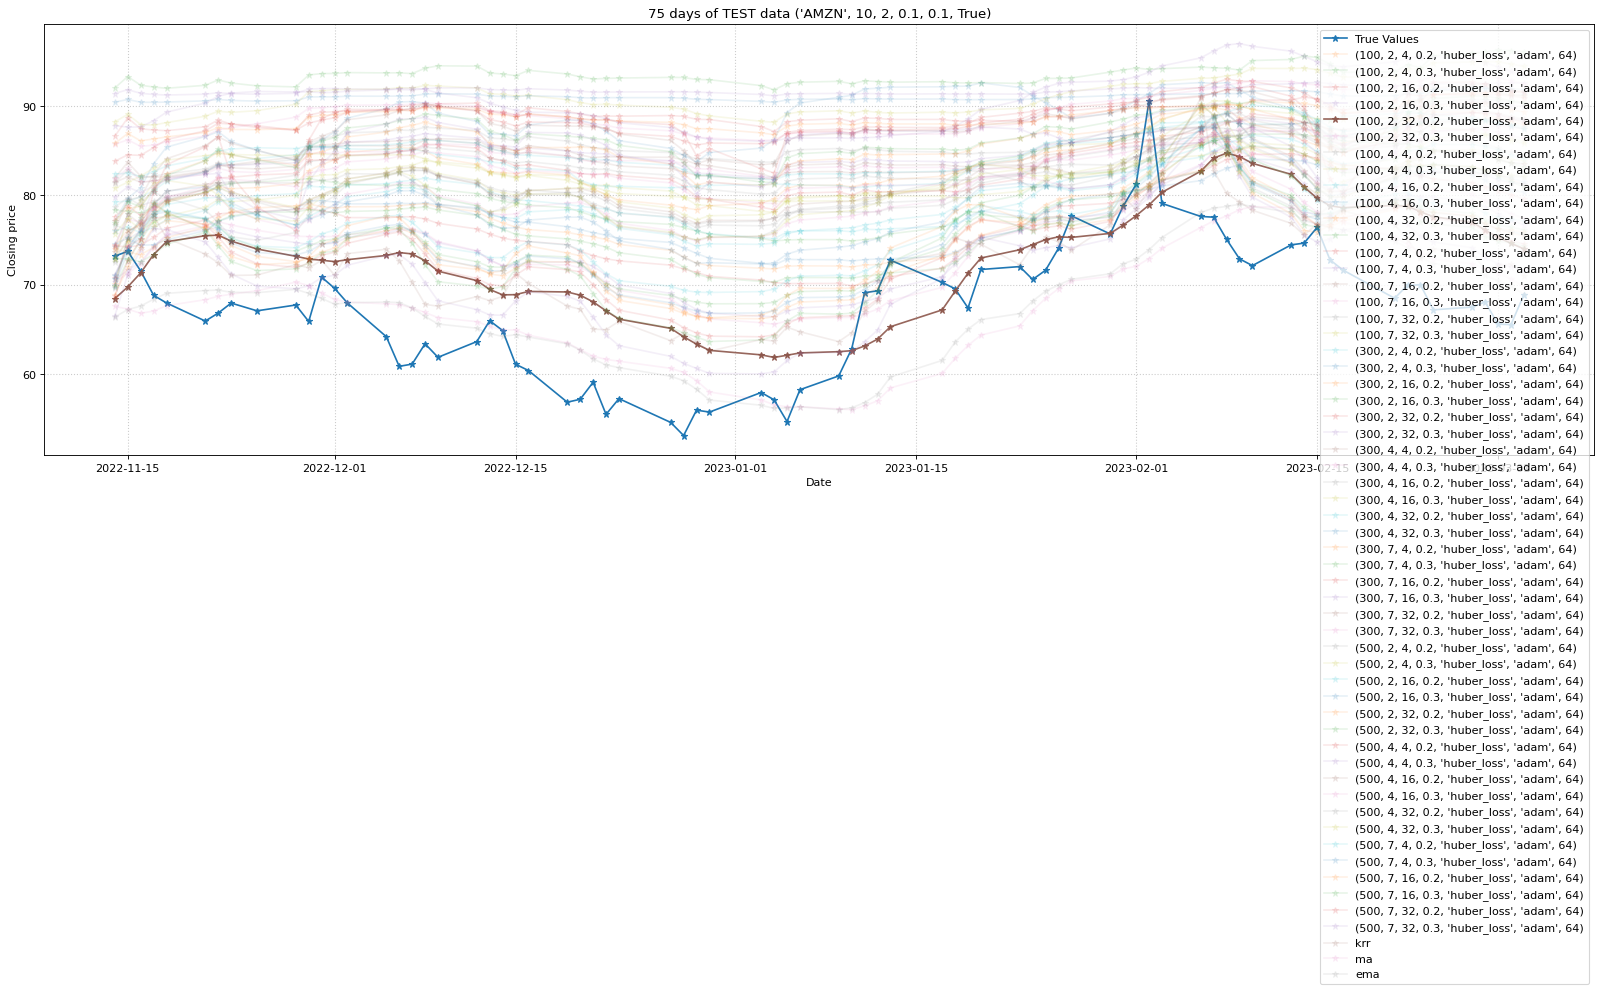

(100, 2, 4, 0.2, huber_loss, adam, 64)  \
MSE                               296.702546   
RMSE                               17.225056   
MAPE                               24.979147   
DA                                  0.459459   
R²                                 -4.648450   

      (100, 2, 4, 0.3, huber_loss, adam, 64)  \
MSE                               207.456887   
RMSE                               14.403364   
MAPE                               20.773382   
DA                                  0.486486   
R²                                 -2.949443   

      (100, 2, 16, 0.2, huber_loss, adam, 64)  \
MSE                                122.635569   
RMSE                                11.074095   
MAPE                                15.392830   
DA                                   0.500000   
R²                                  -1.334664   

      (100, 2, 16, 0.3, huber_loss, adam, 64)  \
MSE                                 84.009060   
RMSE                                 9.165646   
MAPE                                12.610264   
DA                                   0.472973   
R²                                  -0.599316   

      (100, 2, 32, 0.2, huber_loss, adam, 64)  \
MSE                                 53.058465   
RMSE                                 7.284124   
MAPE                                 9.867975   
DA                                   0.445946   
R²                                  -0.010096   

      (100, 2, 32, 0.3, huber_loss, adam, 64)  \
MSE                                 85.957619   
RMSE                                 9.271333   
MAPE                                12.790901   
DA                                   0.459459   
R²                                  -0.636411   

      (100, 4, 4, 0.2, huber_loss, adam, 64)  \
MSE                               393.099060   
RMSE                               19.826726   
MAPE                               28.915042   
DA                                  0.513514   
R²                                 -6.483591   

      (100, 4, 4, 0.3, huber_loss, adam, 64)  \
MSE                               605.756801   
RMSE                               24.612127   
MAPE                               36.490074   
DA                                  0.486486   
R²                                -10.532045   

      (100, 4, 16, 0.2, huber_loss, adam, 64)  \
MSE                                206.676110   
RMSE                                14.376234   
MAPE                                20.476885   
DA                                   0.486486   
R²                                  -2.934579   

      (100, 4, 16, 0.3, huber_loss, adam, 64)  ...  \
MSE                                148.732119  ...   
RMSE                                12.195578  ...   
MAPE                                16.900396  ...   
DA                                   0.459459  ...   
R²                                  -1.831475  ...   

      (500, 4, 32, 0.3, huber_loss, adam, 64)  \
MSE                                206.710769   
RMSE                                14.377440   
MAPE                                20.768717   
DA                                   0.351351   
R²                                  -2.935239   

      (500, 7, 4, 0.2, huber_loss, adam, 64)  \
MSE                               356.117221   
RMSE                               18.871068   
MAPE                               27.680763   
DA                                  0.486486   
R²                                 -5.779552   

      (500, 7, 4, 0.3, huber_loss, adam, 64)  \
MSE                               601.843926   
RMSE                               24.532508   
MAPE                               36.299835   
DA                                  0.527027   
R²                                -10.457554   

      (500, 7, 16, 0.2, huber_loss, adam, 64)  \
MSE                                376.337390   
RMSE                                19.399417   
MAPE                          

AMZN 10 2 0.1 0.1 True 2023-03-04 00_22_07.xlsx


In [49]:
import pickle

# to load
load_file_name = "('AMZN', 10, 2, 0.1, 0.1, True) 2023-03-04 00_22_07.pkl"
with open(f'results/{load_file_name}', 'rb') as f:
    dataset, predictions, data = pickle.load(f)

y = data["ytest"]
# if scaled
if dataset[5]:
    y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))

plot_predictions(data["testDates"], y, predictions, dataset, 'Test', [4])
stats = calc_stats(y, predictions)
excel_file_name = load_file_name.replace('pkl', 'xlsx').replace(',', '').replace(',', '').replace("'","").replace("(","").replace(")","")
print(excel_file_name)

In [53]:
# save the stats onto an excel file
print(f"results/{excel_file_name})")
stats.to_excel(f"results/{excel_file_name}")


results/AMZN 10 2 0.1 0.1 True 2023-03-04 00_22_07.xlsx)


In [206]:


# get results from all the trained networks
for key, net in trained_nets.items():
    model = net
    data = datasets[key[1]]
    # for the training
    pred_ytrain = model.predict(data["xtrain"])
    ytrain = data["ytrain"]
    # scaler = config["data"]["scaler"]
    pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
    ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))

    # for the training
    pred_yval = model.predict(data["xval"])
    yval = data["yval"]
    # scaler = config["data"]["scaler"]
    pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
    yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))

    # for the training
    pred_ytest = model.predict(data["xtest"])
    ytest = data["ytest"]
    # scaler = config["data"]["scaler"]
    pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
    ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
    # ALL 3 TOGETHER
    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    # for the training
    plt.plot(data["trainDates"],ytrain) # train data
    plt.plot(data["trainDates"], pred_ytrain)
    plt.plot(data["valDates"], yval) # val data
    plt.plot(data["valDates"], pred_yval)
    plt.plot(data["testDates"], ytest) # test data
    plt.plot(data["testDates"], pred_ytest)
    plt.title(f"ALL DATA of {key}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(data['xtest'][:, -1, :])
    pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


    # calcualte the price using a simple moving average
    pred_ma = np.mean(data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

    # calculate the price using exponential moving average
    pred_ema = data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, key[0][0]))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    plt.plot(ytest, "*-") # actual data
    plt.plot(pred_ytest, "*-") # prediction made by neural network
    plt.plot(pred_ma, "*-")
    plt.plot(pred_ema, "*-")
    plt.plot(pred_krr, "*-")
    plt.title(f"Testing data of {config['data']['ticker']}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    xticks = 100
    step = round(len(data["raw"]["adjclose"].keys())/xticks)
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
    plt.show()

    # compare all the following data
    pairs = [[ytrain, pred_ytrain, 'Training NN'],
            [yval, pred_yval, 'Validation NN'],
            [ytest, pred_ytest, 'Testing NN'],
            [ytest, pred_krr, 'Testing KRR'],
            [ytest, pred_ma, 'Testing MA'],
            [ytest, pred_ema, 'Testing EMA']
            ]
    d = {}
    for pair in pairs:
        d[pair[2]] = []
        d[pair[2]].append(calc_mse(pair[0], pair[1]))
        d[pair[2]].append(calc_rmse(pair[0], pair[1]))
        # d[pair[2]].append(calc_mae(pair[0], pair[1]))
        d[pair[2]].append(calc_mape(pair[0], pair[1]))
        d[pair[2]].append(calc_da(pair[0], pair[1]))
        d[pair[2]].append(calc_cod(pair[0], pair[1]))

    df = pd.DataFrame(data=d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
    display(df)

{'dataset': ('TSLA', 10, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x3839c5540>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x4642cf880>}}

{'dataset': ('TSLA', 50, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x39ccbf610>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x4805f3b50>}}

{'dataset': ('AMZN', 10, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x471e3e620>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x319355090>}}

{'dataset': ('AMZN', 50, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x3f664c940>, (2, 2, 256, 0.3, 'huber_loss', 'ad

In [124]:
import itertools
# setup different models
networks = {} # setup a dictionary to save all the models generated
for opts in itertools.product(windows, layers, num_neurons, dropouts, loss_functions, optimizers):
    print(opts)
    # create a model using the options in CONFIG
    model = generateModel(opts[0], opts[1], opts[2], n_features= config["nn"]["nFeatures"], dropout= opts[3], loss= opts[4], optimizer= opts[5], layerType= config["nn"]["layerType"])
    # store the models in a dictionary
    networks[opts] = model

# download all the different data
stocks = {}
for ticker in tickers:
    stocks[ticker] = getData(ticker, config["data"]["offset"])

(10, 2, 256, 0.3, 'huber_loss', 'adam')
(50, 2, 256, 0.3, 'huber_loss', 'adam')
TSLA data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data
AMZN data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data


In [112]:
# setup the different data with different settings
# process all the different data
datasets = {}
for opts in itertools.product(tickers, windows, lookaheads, validations, tests, scaled):
    print(opts)
    # process the data with all of the settings
    datasets[opts] = setupData(stocks[opts[0]], opts[1], opts[2], opts[3], opts[4], opts[5], config["data"]["scaler"], config["data"]["inputs"])

('TSLA', 10, 2, 0.1, 0.1, True)
('TSLA', 50, 2, 0.1, 0.1, True)
('AMZN', 10, 2, 0.1, 0.1, True)
('AMZN', 50, 2, 0.1, 0.1, True)


In [113]:
# train the models
trained_nets = {}
for opts in itertools.product(networks.keys(), datasets.keys(), epochs, batch_size):
    # only train if the windows match
    if opts[0][0] == opts[1][1]:
        trained_nets[opts] = networks[opts[0]]
        print(opts)
        trained_nets[opts].fit(datasets[opts[1]]["xtrain"], datasets[opts[1]]["ytrain"], batch_size= opts[3], epochs= opts[2], validation_data=(datasets[opts[1]]["xval"], datasets[opts[1]]["yval"]), verbose=1)

# for key, data in m.items():
#     print(key)

# show the results
# for key, data in datasets.items():
#     print(key, data.keys())
#     plots = "trainDates ytrain,valDates yval,testDates ytest"
#     lines = 100
#     fig = plt.figure(figsize=(25, 7), dpi=80)
#     # plot all the different lines
#     for plot in plots.split(","):
#         x, y = plot.split()
#         plt.plot(data[f"{x}"], data[f"{y}"])
#     step = round(len(data["raw"]["adjclose"].keys())/lines)
#     plt.xticks(data["ydates"][::step], rotation='vertical') 
#     # Plot the grid lines
#     plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
#     scaled = lambda x: "Scaled " if x == True else None
#     plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {key}", fontsize=16)
#     # Define the labels for x-axis and y-axis
#     plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
#     plt.xlabel("Date", fontsize=14)
#     plt.legend("Train,Validation,Test".split(","))
#     # show the plot
#     plt.show()

((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 1, 64)


2023-02-27 21:48:57.964316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.181705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.344817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.595692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.790125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.1944

2023-02-27 21:48:59.883107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:59.958030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:00.021562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 143ms/step - loss: 0.0370 - mean_absolute_error: 0.1944 - val_loss: 0.0131 - val_mean_absolute_error: 0.1524
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0053 - mean_absolute_error: 0.0811 - val_loss: 0.0014 - val_mean_absolute_error: 0.0431
Epoch 2/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0029 - mean_absolute_error: 0.0554 - val_loss: 0.0024 - val_mean_absolute_error: 0.0556
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 1, 64)
10/10 [==============================] - 0s 31ms/step - loss: 0.0031 - mean_absolute_error: 0.0608 - val_loss: 0.0037 - val_mean_absolute_error: 0.0701
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 30ms/step - loss: 0.0028 - mean_absolute_error: 0.0574 - val_loss: 0.00

2023-02-27 21:49:03.446364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.654132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.805955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:04.049173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 19s - loss: 0.1782 - mean_absolute_error: 0.5589

2023-02-27 21:49:04.304594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.2340

2023-02-27 21:49:05.782343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.858981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.979124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 227ms/step - loss: 0.0478 - mean_absolute_error: 0.2340 - val_loss: 0.0083 - val_mean_absolute_error: 0.1138
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 55ms/step - loss: 0.0062 - mean_absolute_error: 0.0873 - val_loss: 0.0027 - val_mean_absolute_error: 0.0627
Epoch 2/2
9/9 [==============================] - 0s 52ms/step - loss: 0.0039 - mean_absolute_error: 0.0664 - val_loss: 0.0041 - val_mean_absolute_error: 0.0749
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 1, 64)
9/9 [==============================] - 0s 51ms/step - loss: 0.0038 - mean_absolute_error: 0.0665 - val_loss: 0.0046 - val_mean_absolute_error: 0.0788
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0578 - val_loss: 0.0048 - val_m

3/3 [==============================] - 0s 9ms/step


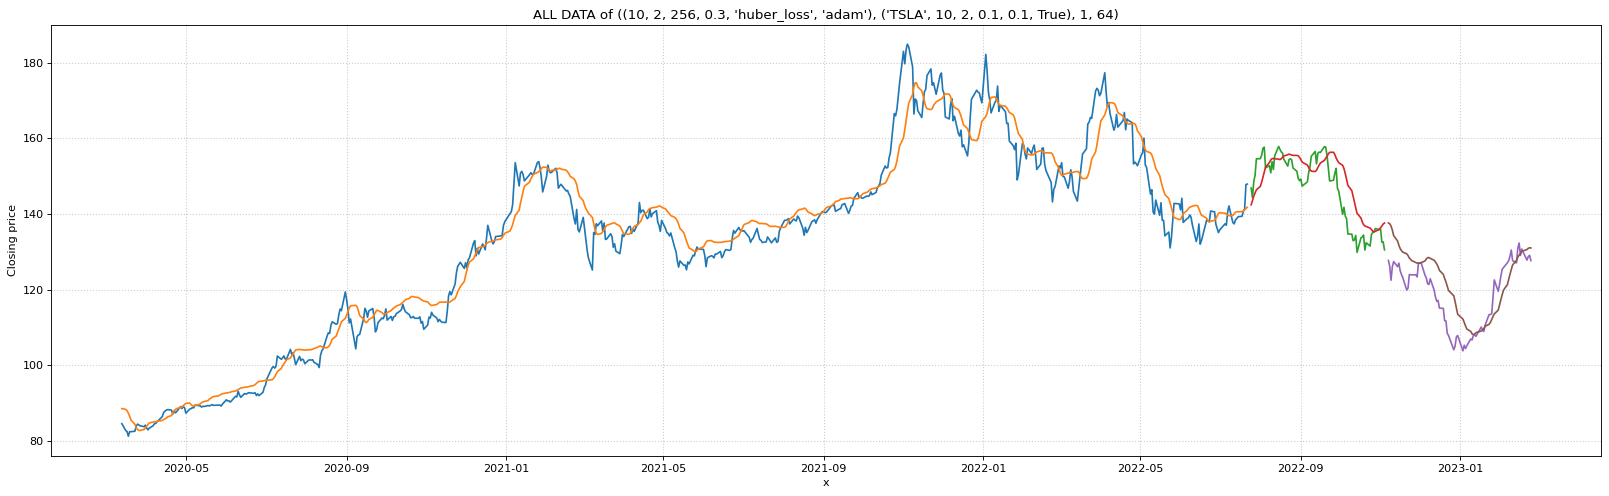

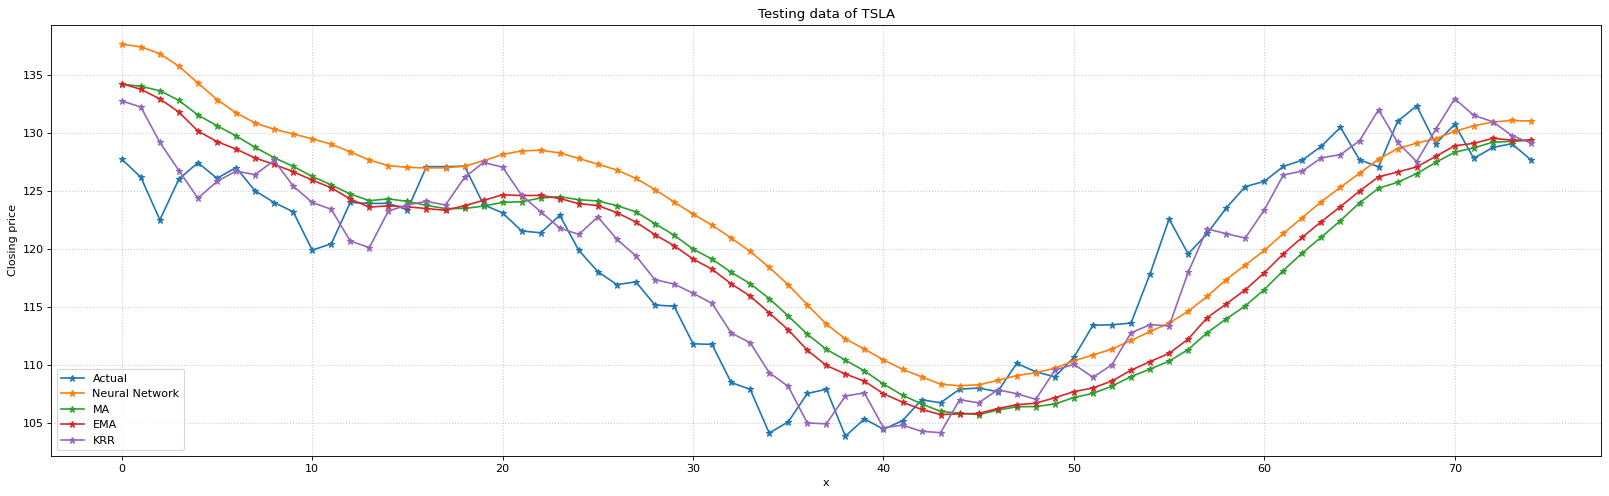

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     27.119308      32.125907   43.076969     9.715144   33.113784   
RMSE     5.207620       5.667972    6.563305     3.116913    5.754458   
MAPE     2.811787       3.175840    4.586855     2.188323    4.086181   
DA       0.533670       0.479452    0.608108     0.554054    0.608108   
R²       0.956521       0.621400    0.392340     0.862955    0.532885   

      Testing EMA  
MSE     25.897184  
RMSE     5.088928  
MAPE     3.597360  
DA       0.635135  
R²       0.634685

3/3 [==============================] - 0s 7ms/step


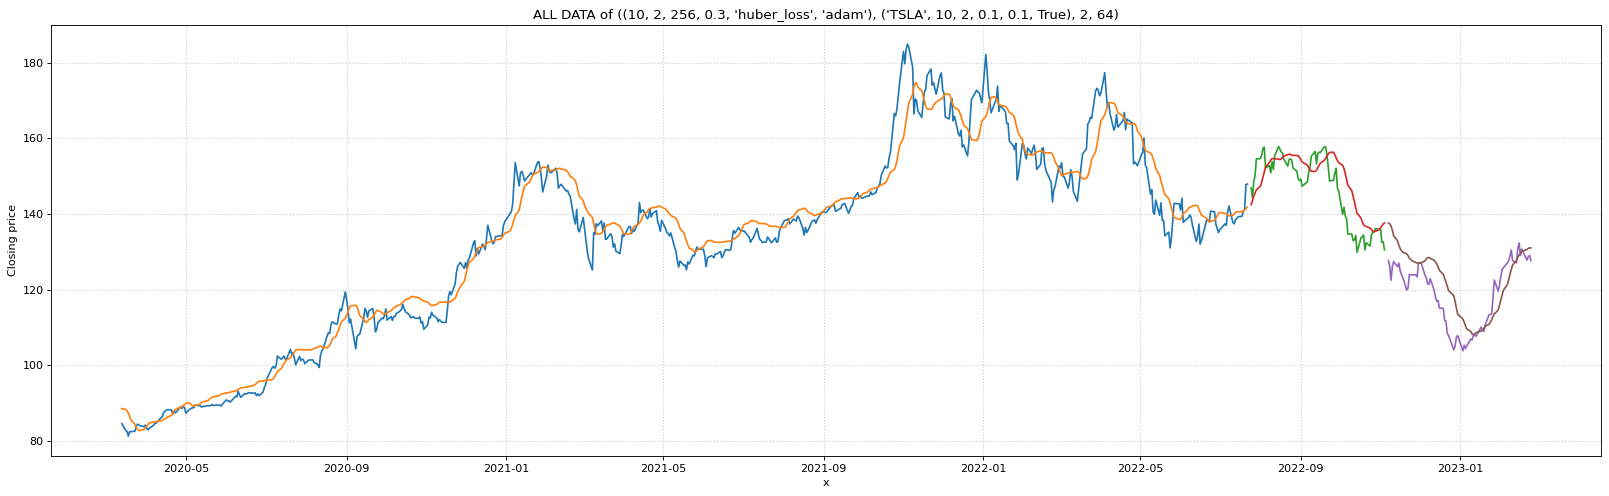

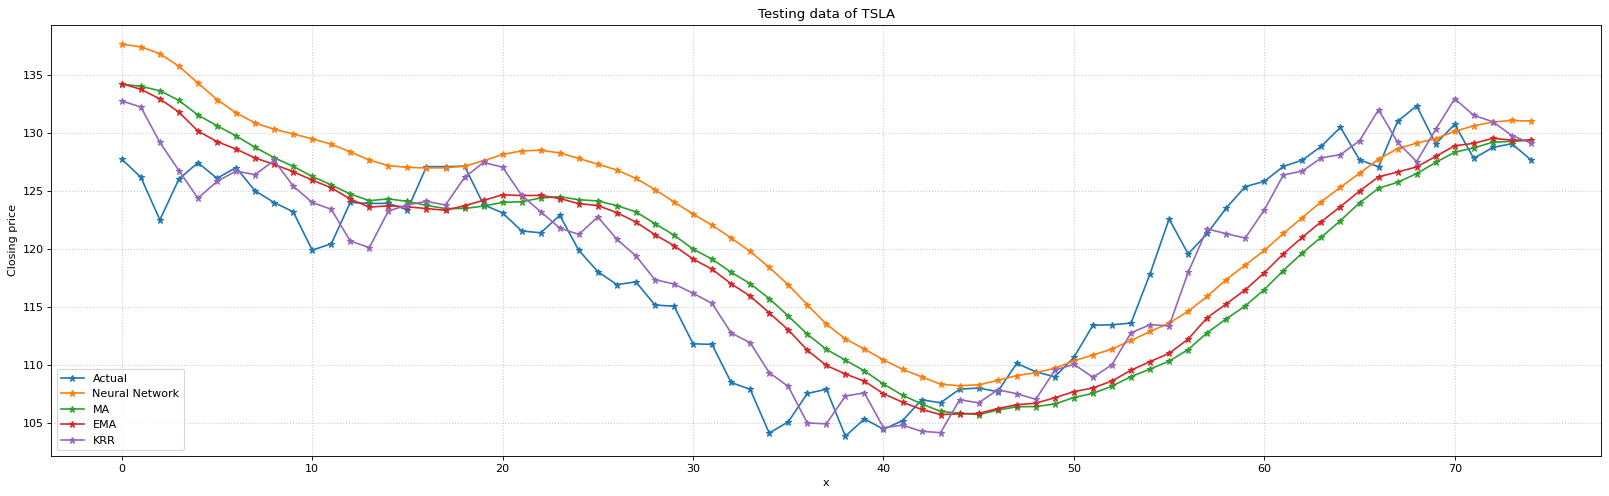

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     27.119308      32.125907   43.076969     9.715144   33.113784   
RMSE     5.207620       5.667972    6.563305     3.116913    5.754458   
MAPE     2.811787       3.175840    4.586855     2.188323    4.086181   
DA       0.533670       0.479452    0.608108     0.554054    0.608108   
R²       0.956521       0.621400    0.392340     0.862955    0.532885   

      Testing EMA  
MSE     25.897184  
RMSE     5.088928  
MAPE     3.597360  
DA       0.635135  
R²       0.634685

3/3 [==============================] - 0s 9ms/step


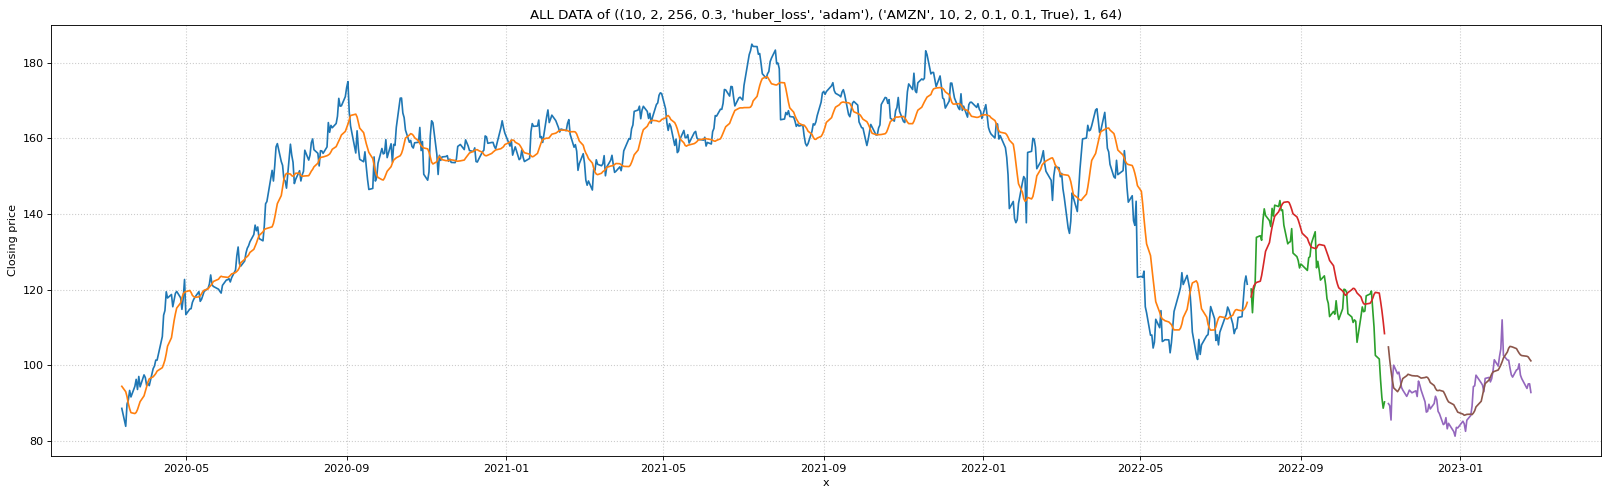

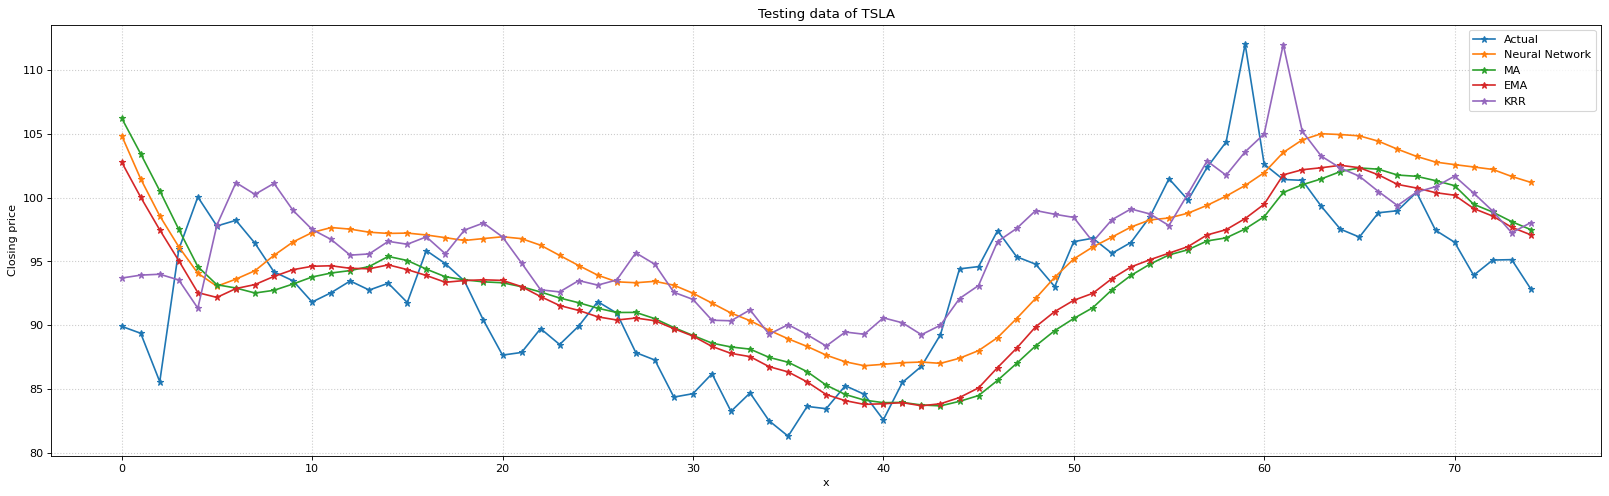

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     44.163843      86.052719   33.586390    23.967551   30.088705   
RMSE     6.645588       9.276460    5.795377     4.895667    5.485317   
MAPE     3.468451       6.538713    5.334824     4.572693    4.562467   
DA       0.491582       0.493151    0.486486     0.445946    0.513514   
R²       0.907979       0.476810    0.097896     0.356251    0.191841   

      Testing EMA  
MSE     23.878797  
RMSE     4.886594  
MAPE     4.124785  
DA       0.500000  
R²       0.358635

3/3 [==============================] - 0s 11ms/step


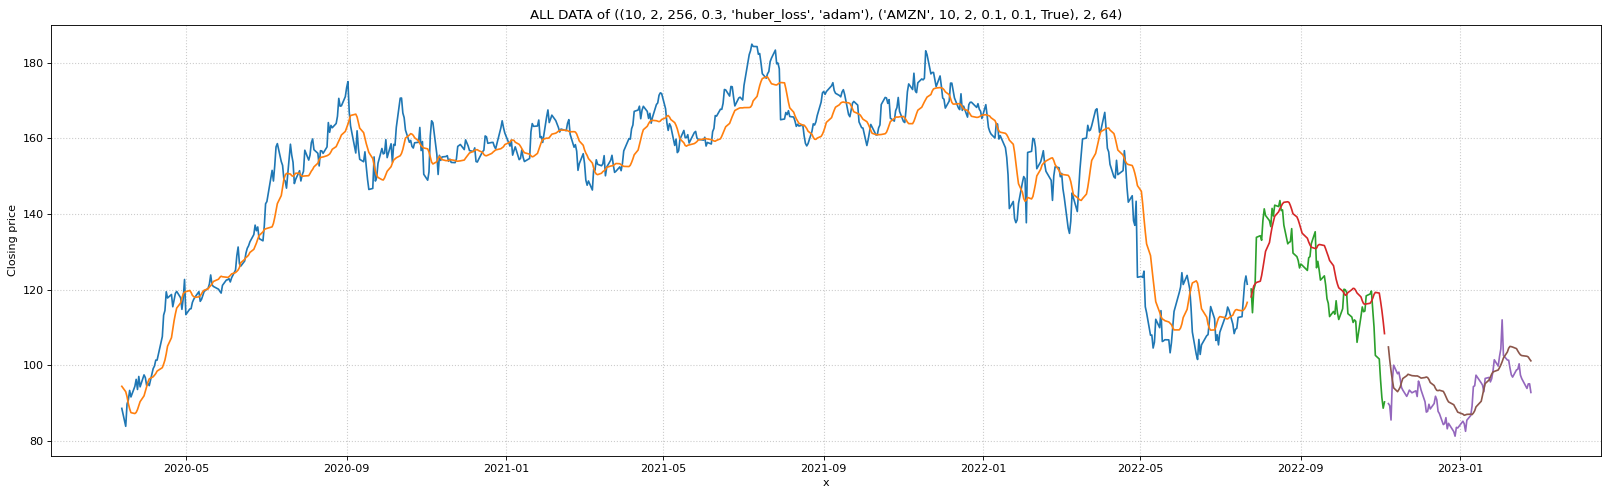

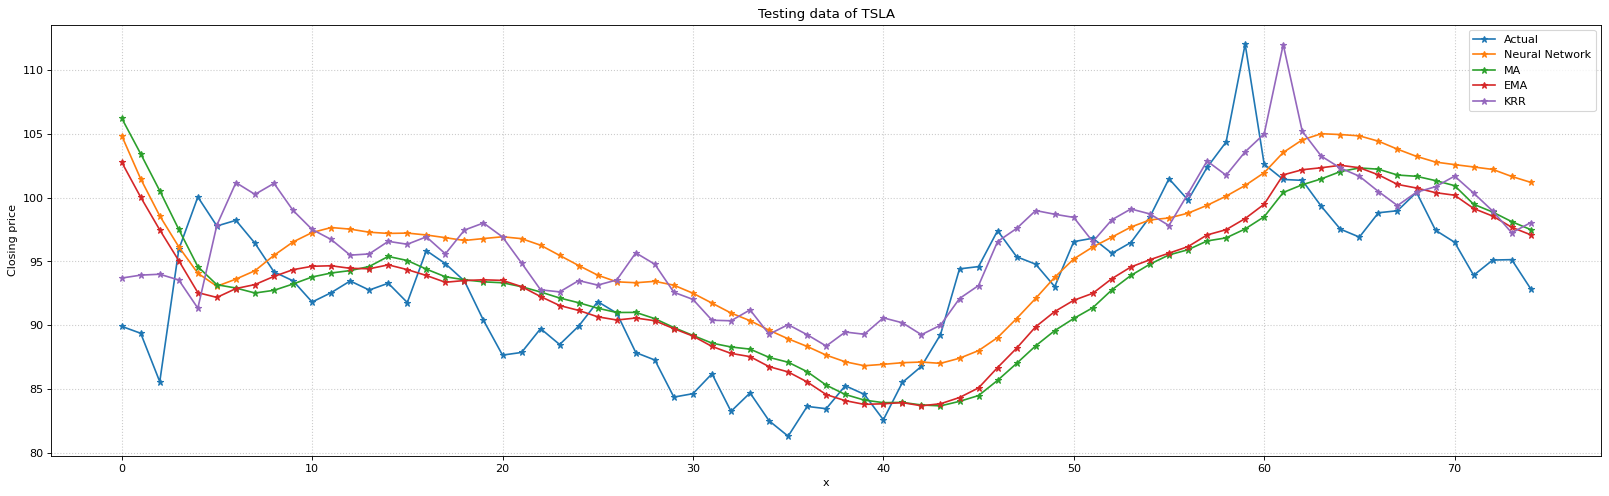

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     44.163843      86.052719   33.586390    23.967551   30.088705   
RMSE     6.645588       9.276460    5.795377     4.895667    5.485317   
MAPE     3.468451       6.538713    5.334824     4.572693    4.562467   
DA       0.491582       0.493151    0.486486     0.445946    0.513514   
R²       0.907979       0.476810    0.097896     0.356251    0.191841   

      Testing EMA  
MSE     23.878797  
RMSE     4.886594  
MAPE     4.124785  
DA       0.500000  
R²       0.358635

3/3 [==============================] - 0s 28ms/step


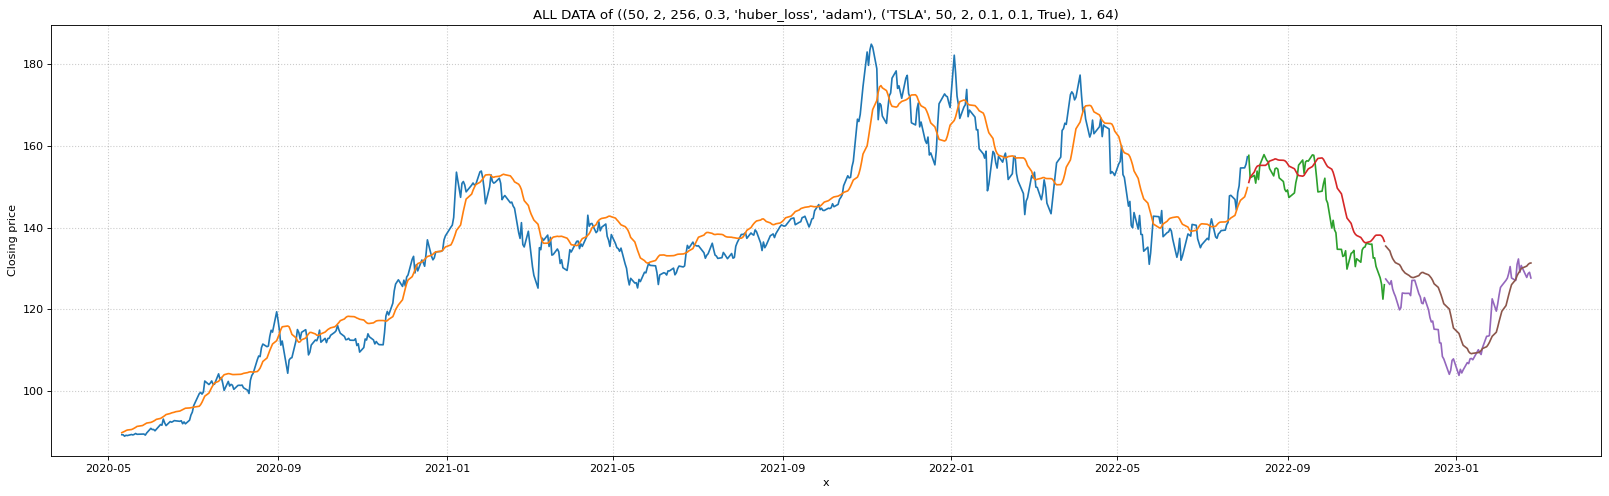

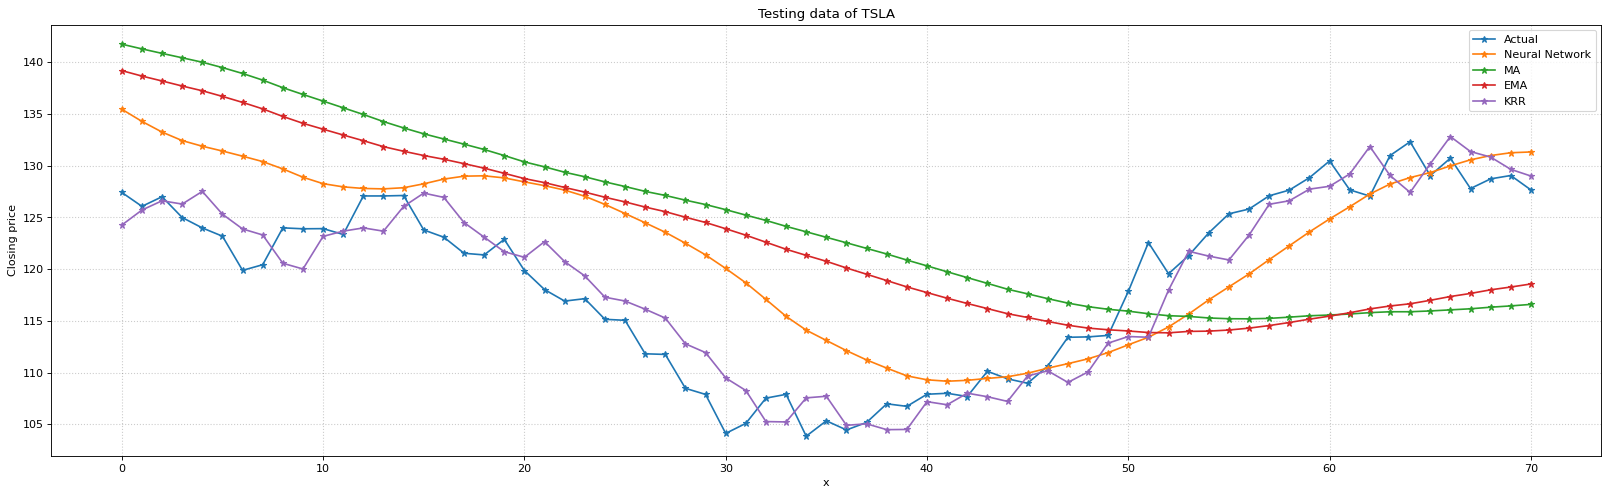

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     32.991605      48.819729   49.949015     8.603780  169.921437   
RMSE     5.743832       6.987112    7.067462     2.933220   13.035392   
MAPE     3.139381       3.965914    5.041390     2.080039   10.452921   
DA       0.540925       0.463768    0.585714     0.542857    0.514286   
R²       0.933700       0.544219    0.309349     0.881034   -1.349525   

      Testing EMA  
MSE    131.947238  
RMSE    11.486829  
MAPE     9.115134  
DA       0.585714  
R²      -0.824451

3/3 [==============================] - 0s 17ms/step


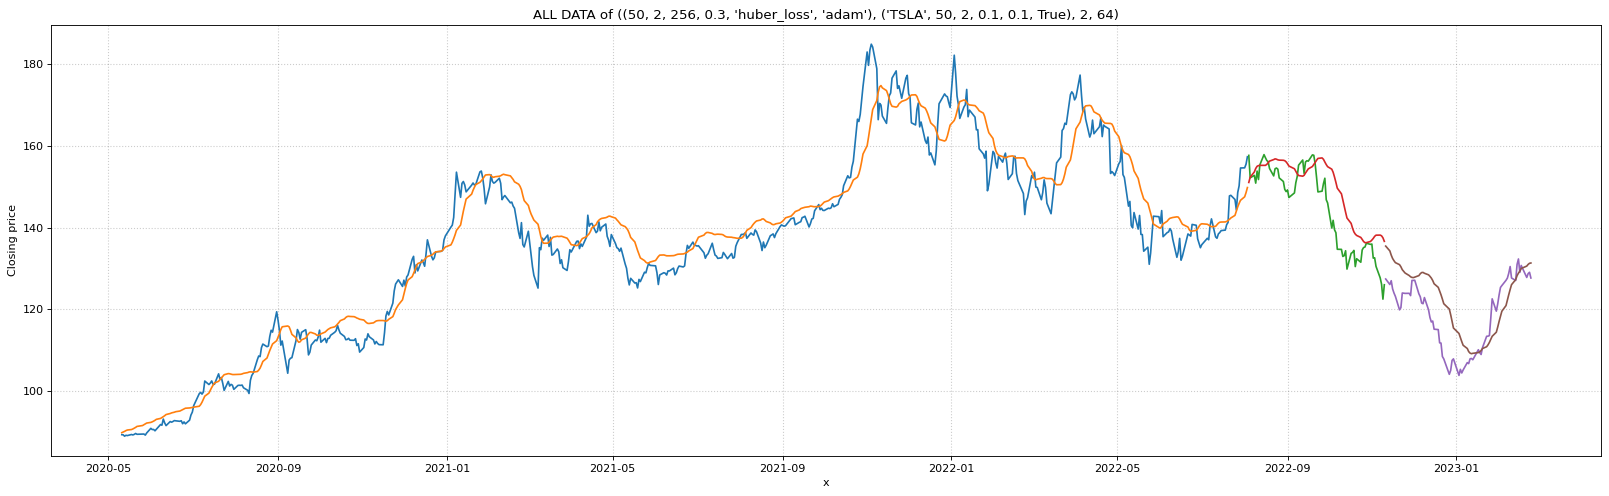

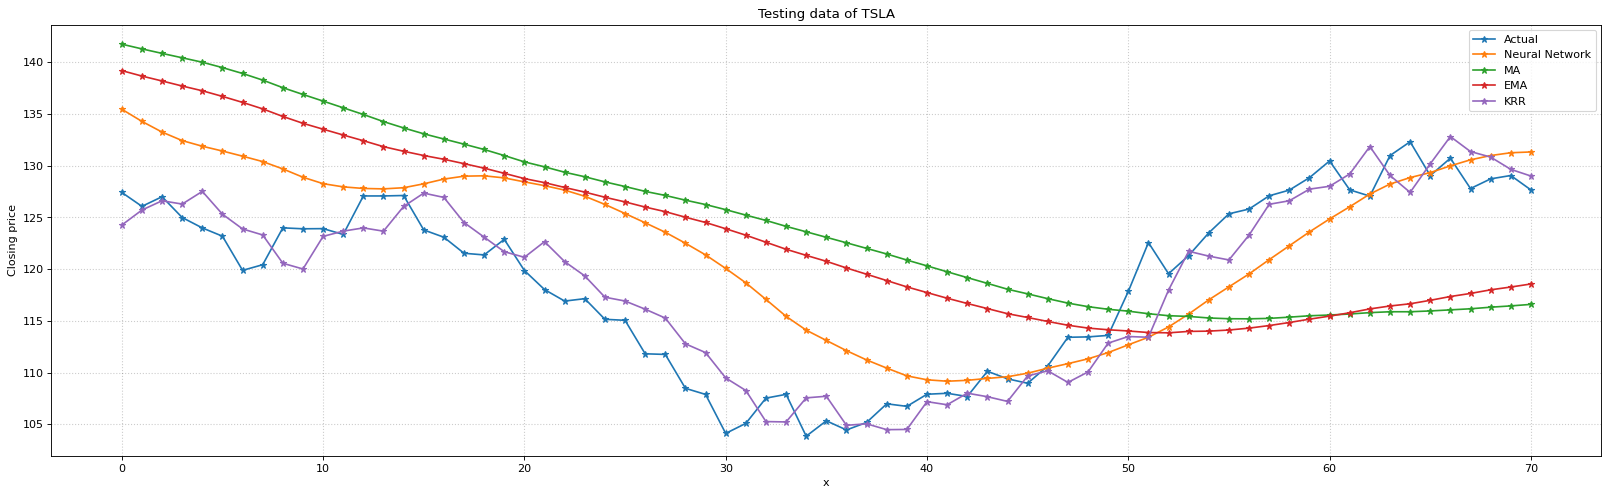

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     32.991605      48.819729   49.949015     8.603780  169.921437   
RMSE     5.743832       6.987112    7.067462     2.933220   13.035392   
MAPE     3.139381       3.965914    5.041390     2.080039   10.452921   
DA       0.540925       0.463768    0.585714     0.542857    0.514286   
R²       0.933700       0.544219    0.309349     0.881034   -1.349525   

      Testing EMA  
MSE    131.947238  
RMSE    11.486829  
MAPE     9.115134  
DA       0.585714  
R²      -0.824451

3/3 [==============================] - 0s 19ms/step


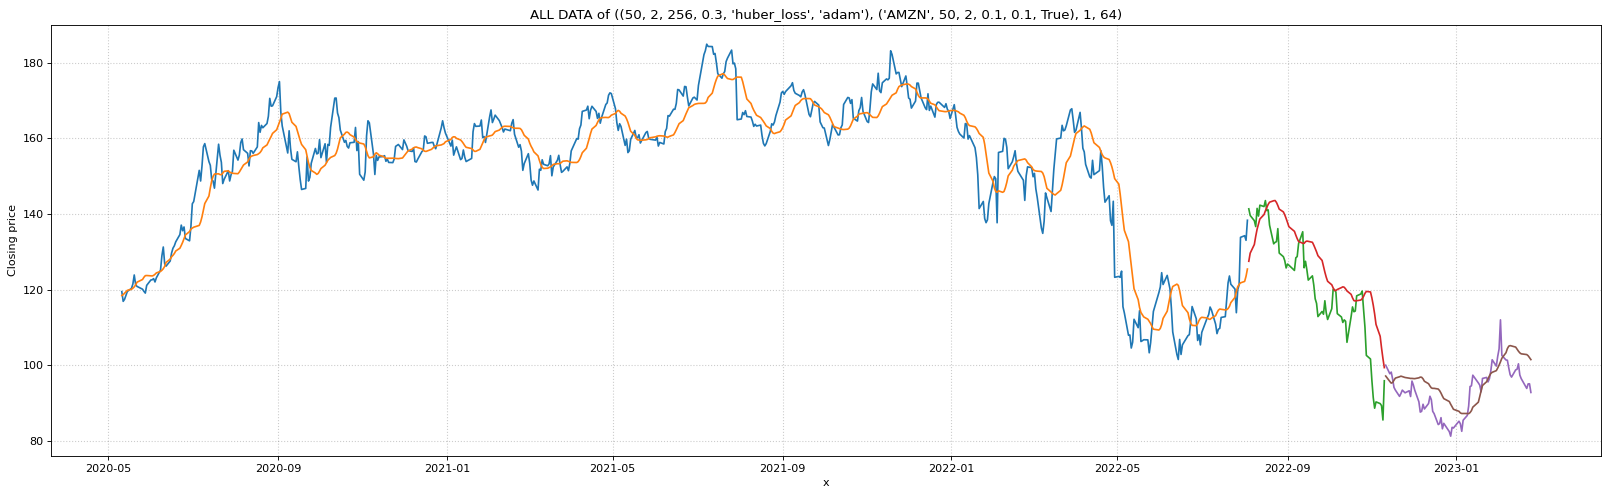

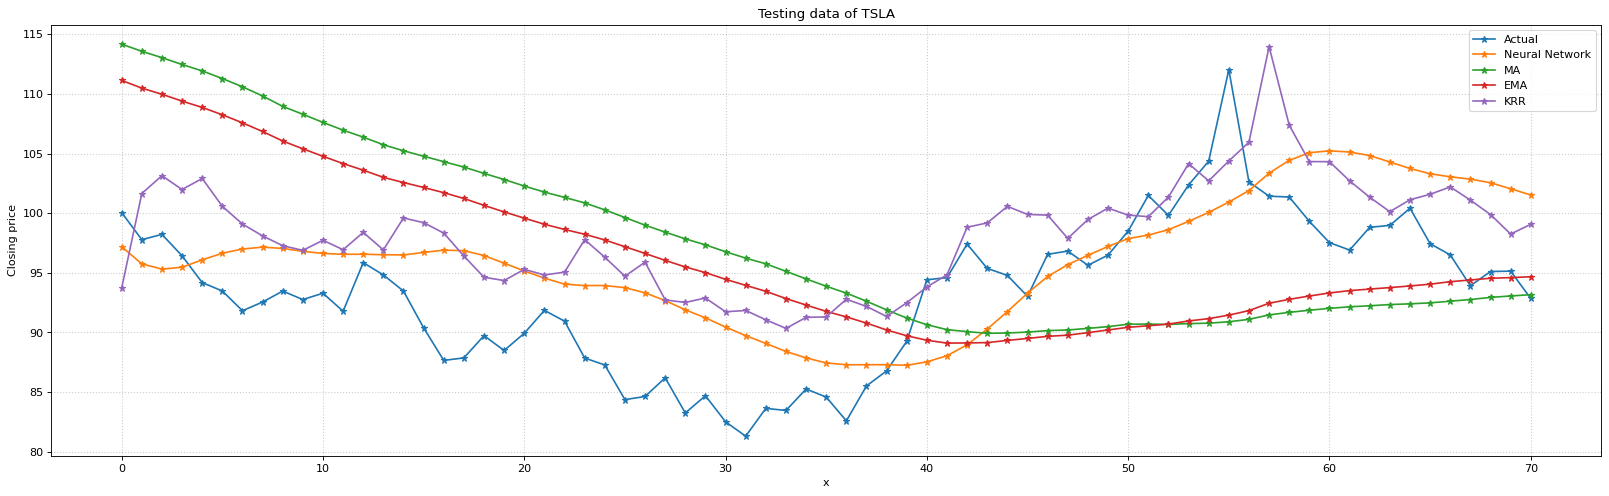

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     47.508294     110.007219   29.531121    37.968501  131.299272   
RMSE     6.892626      10.488433    5.434254     6.161859   11.458589   
MAPE     3.484255       7.764645    5.102725     5.979233   11.239135   
DA       0.491103       0.521739    0.485714     0.500000    0.528571   
R²       0.866464       0.496209    0.223879     0.002133   -2.450736   

      Testing EMA  
MSE     93.997416  
RMSE     9.695226  
MAPE     9.482228  
DA       0.514286  
R²      -1.470389

3/3 [==============================] - 0s 16ms/step


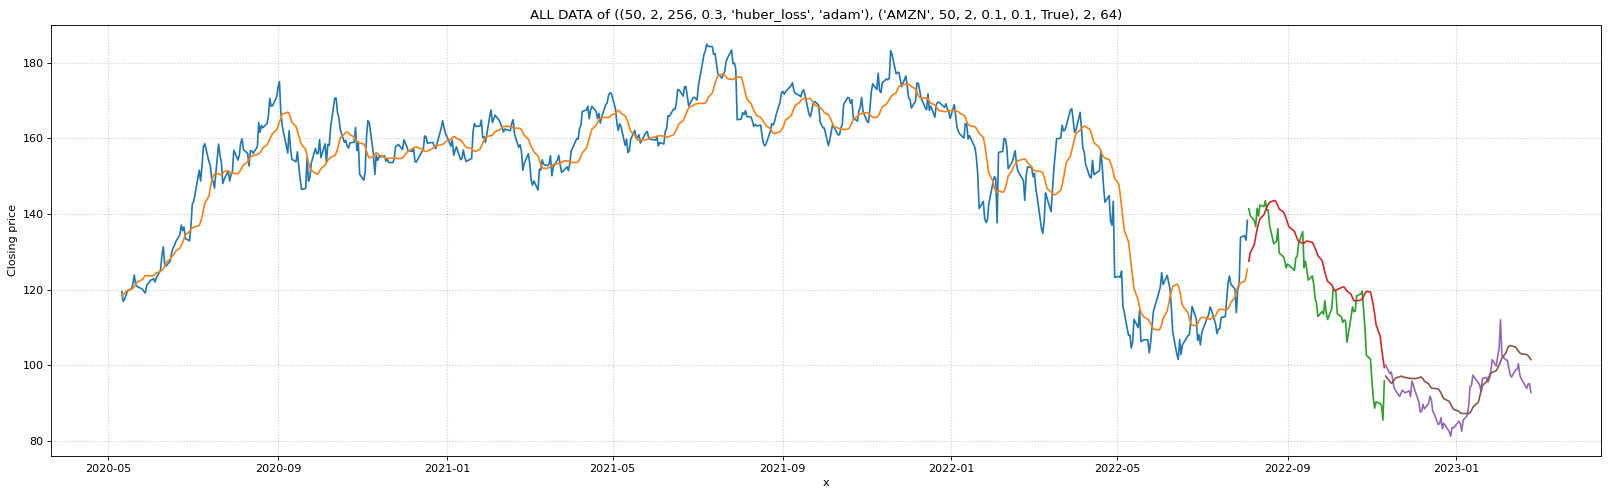

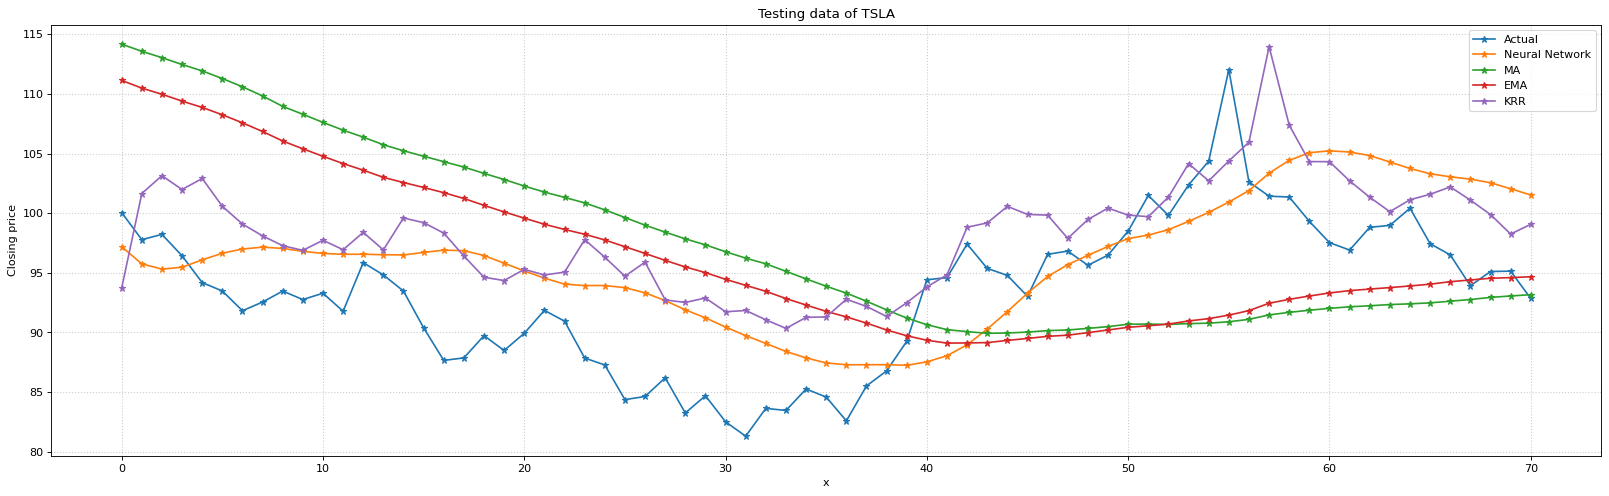

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     47.508294     110.007219   29.531121    37.968501  131.299272   
RMSE     6.892626      10.488433    5.434254     6.161859   11.458589   
MAPE     3.484255       7.764645    5.102725     5.979233   11.239135   
DA       0.491103       0.521739    0.485714     0.500000    0.528571   
R²       0.866464       0.496209    0.223879     0.002133   -2.450736   

      Testing EMA  
MSE     93.997416  
RMSE     9.695226  
MAPE     9.482228  
DA       0.514286  
R²      -1.470389

In [123]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# get results from all the trained networks
for key, net in trained_nets.items():
    model = net
    data = datasets[key[1]]
    # for the training
    pred_ytrain = model.predict(data["xtrain"])
    ytrain = data["ytrain"]
    # scaler = config["data"]["scaler"]
    pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
    ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))

    # for the training
    pred_yval = model.predict(data["xval"])
    yval = data["yval"]
    # scaler = config["data"]["scaler"]
    pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
    yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))

    # for the training
    pred_ytest = model.predict(data["xtest"])
    ytest = data["ytest"]
    # scaler = config["data"]["scaler"]
    pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
    ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
    # ALL 3 TOGETHER
    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    # for the training
    plt.plot(data["trainDates"],ytrain) # train data
    plt.plot(data["trainDates"], pred_ytrain)
    plt.plot(data["valDates"], yval) # val data
    plt.plot(data["valDates"], pred_yval)
    plt.plot(data["testDates"], ytest) # test data
    plt.plot(data["testDates"], pred_ytest)
    plt.title(f"ALL DATA of {key}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(data['xtest'][:, -1, :])
    pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


    # calcualte the price using a simple moving average
    pred_ma = np.mean(data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

    # calculate the price using exponential moving average
    pred_ema = data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, key[0][0]))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    plt.plot(ytest, "*-") # actual data
    plt.plot(pred_ytest, "*-") # prediction made by neural network
    plt.plot(pred_ma, "*-")
    plt.plot(pred_ema, "*-")
    plt.plot(pred_krr, "*-")
    plt.title(f"Testing data of {config['data']['ticker']}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    xticks = 100
    step = round(len(data["raw"]["adjclose"].keys())/xticks)
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
    plt.show()

    # compare all the following data
    pairs = [[ytrain, pred_ytrain, 'Training NN'],
            [yval, pred_yval, 'Validation NN'],
            [ytest, pred_ytest, 'Testing NN'],
            [ytest, pred_krr, 'Testing KRR'],
            [ytest, pred_ma, 'Testing MA'],
            [ytest, pred_ema, 'Testing EMA']
            ]
    d = {}
    for pair in pairs:
        d[pair[2]] = []
        d[pair[2]].append(calc_mse(pair[0], pair[1]))
        d[pair[2]].append(calc_rmse(pair[0], pair[1]))
        # d[pair[2]].append(calc_mae(pair[0], pair[1]))
        d[pair[2]].append(calc_mape(pair[0], pair[1]))
        d[pair[2]].append(calc_da(pair[0], pair[1]))
        d[pair[2]].append(calc_cod(pair[0], pair[1]))

    df = pd.DataFrame(data=d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
    display(df)